# DBA4811 Final Project Analytics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TunedThresholdClassifierCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, make_scorer, confusion_matrix, classification_report, ConfusionMatrixDisplay

## Preview data

In [2]:
df = pd.read_csv("data.csv")
df.head()

,age,avg_glucose_level,bmi,stroke,hypertension,heart_disease,gender_male,ever_married_yes,employment_status_unemployed,residence_type_urban,smoker_status_never,smoker_status_smoker,smoker_status_unknown
0,67.0,228.69,36.6,1,0,1,1,1,0,1,0,0,0
1,61.0,202.21,28.1,1,0,0,0,1,0,0,1,0,0
2,80.0,105.92,32.5,1,0,1,1,1,0,0,1,0,0
3,49.0,171.23,34.4,1,0,0,0,1,0,1,0,1,0
4,79.0,174.12,24.0,1,1,0,0,1,0,0,1,0,0


## Set fixed parameters for reproducibility

In [3]:
# Set random state
STATE_NUM = 42

# Set number of cross-validation splits
CV_SPLITS = 5

# Set test size
T_SIZE = 0.2

# Numeric features (For scaling after train-test-split to avoid data leakage)
NUMERIC_FEATURES = ["age", "avg_glucose_level", "bmi"]

## Sample Approach Breakdown

In [4]:
# Split into features and target
X = df.drop("stroke", axis = 1, inplace = False)
X["avg_glucose_level"] = np.log(X["avg_glucose_level"]) # Log transform for better normalization
y = df["stroke"]

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = T_SIZE, random_state = STATE_NUM)

# Scale data after train-test split to avoid data leakage
scaler = StandardScaler()
X_train[NUMERIC_FEATURES] = scaler.fit_transform(X_train[NUMERIC_FEATURES])
X_test[NUMERIC_FEATURES] = scaler.transform(X_test[NUMERIC_FEATURES])

In [5]:
mod = GridSearchCV(estimator = LogisticRegression(solver = "saga", penalty = "elasticnet", random_state = STATE_NUM, max_iter = 1000, class_weight = "balanced"),
                   param_grid = {
                        "C": [0.01, 0.1],
                        "l1_ratio": np.arange(0, 1.1, 0.2)
                    },
                    scoring = {
                        "accuracy": make_scorer(accuracy_score), 
                        "recall": make_scorer(recall_score),
                        "f1_score": make_scorer(f1_score), 
                        "roc_auc_score": make_scorer(roc_auc_score)
                    },
                    refit = "recall",
                    cv = CV_SPLITS,
                    n_jobs = -1)

mod.fit(X_train, y_train)
gs_df = pd.DataFrame(mod.cv_results_)
gs_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_f1_score,rank_test_f1_score,split0_test_roc_auc_score,split1_test_roc_auc_score,split2_test_roc_auc_score,split3_test_roc_auc_score,split4_test_roc_auc_score,mean_test_roc_auc_score,std_test_roc_auc_score,rank_test_roc_auc_score
0,0.056069,0.004242,0.035813,0.006183,0.01,0.0,"{'C': 0.01, 'l1_ratio': 0.0}",0.705379,0.720049,0.709046,...,0.016943,7,0.729851,0.803138,0.759818,0.765610,0.802945,0.772272,0.027902,3
1,0.066516,0.006952,0.029585,0.006714,0.01,0.2,"{'C': 0.01, 'l1_ratio': 0.2}",0.704156,0.715159,0.706601,...,0.017015,8,0.729211,0.800574,0.771053,0.750814,0.804868,0.771304,0.028896,5
2,0.054210,0.007147,0.027243,0.004515,0.01,0.4,"{'C': 0.01, 'l1_ratio': 0.4}",0.706601,0.712714,0.699267,...,0.013491,9,0.730491,0.799291,0.767206,0.751455,0.786868,0.767062,0.024544,9
3,0.057191,0.006867,0.025496,0.001592,0.01,0.6,"{'C': 0.01, 'l1_ratio': 0.6000000000000001}",0.711491,0.712714,0.695599,...,0.012301,10,0.733052,0.799291,0.765283,0.750173,0.784945,0.766549,0.023674,10
4,0.051597,0.006210,0.029496,0.003232,0.01,0.8,"{'C': 0.01, 'l1_ratio': 0.8}",0.710269,0.711491,0.694377,...,0.012435,11,0.732412,0.798650,0.764642,0.750814,0.784945,0.766293,0.023601,11


In [6]:
best_model = mod.best_estimator_
print(f"Best model (Highest Recall Score): {best_model}")

y_pred = best_model.predict(X_test)

test_roc_auc, test_f1_score, test_acc_score, test_recall_score = roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred), accuracy_score(y_test, y_pred), recall_score(y_test, y_pred)

print(f"Test F1 Score: {round(test_f1_score, 4)}")
print(f"Test Accuracy Score: {round(test_acc_score, 4)}")
print(f"Test Recall Score: {test_recall_score}")

Best model (Highest Recall Score): LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=0.0, max_iter=1000,
                   penalty='elasticnet', random_state=42, solver='saga')
Test F1 Score: 0.2755
Test Accuracy Score: 0.7427
Test Recall Score: 0.8064516129032258


              precision    recall  f1-score   support

           0       0.98      0.74      0.84       960
           1       0.17      0.81      0.28        62

    accuracy                           0.74      1022
   macro avg       0.57      0.77      0.56      1022
weighted avg       0.93      0.74      0.81      1022



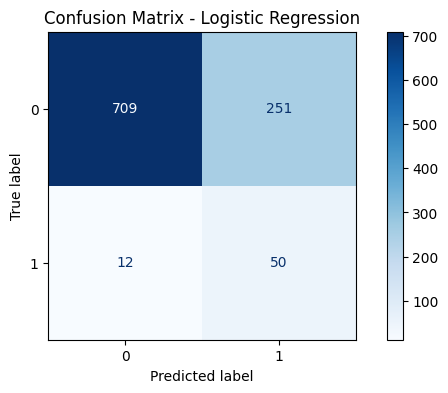

In [7]:
print(classification_report(y_test, y_pred))

cm1 = confusion_matrix(y_test, y_pred)

cmp1 = ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = best_model.classes_)
fig, ax = plt.subplots(figsize = (8,4))
cmp1.plot(ax = ax, cmap = "Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

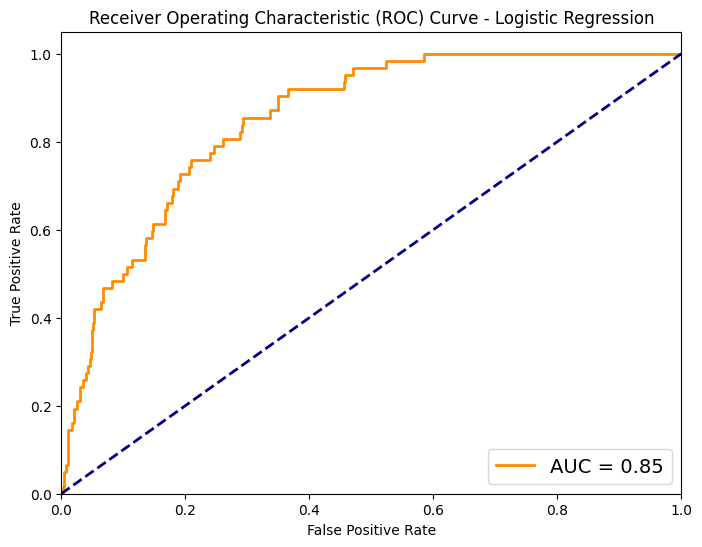

In [8]:
# Predict probabilities on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - Logistic Regression")
plt.legend(loc = "lower right", fontsize = 14)
plt.show()

In [9]:
# With cross-validation for threshold tuning ON TRAINING SET ONLY TO AVOID OVERFITTING
classifier_tuned = TunedThresholdClassifierCV(best_model, scoring = "balanced_accuracy").fit(X_train, y_train)
print(f"Optimal Cut-off point for validation set found at {classifier_tuned.best_threshold_:.3f}")

# Get predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]

# Adjust the threshold based on tuned classifier
threshold = classifier_tuned.best_threshold_
y_pred_new = (y_probs >= threshold).astype(int)

# Print test scores with modified threshold based on tuned classifier
mod_rec_score, mod_f1_score, mod_acc_score, = recall_score(y_test, y_pred_new), f1_score(y_test, y_pred_new), accuracy_score(y_test, y_pred_new)

print(f"Modified Recall Score  : {round(mod_rec_score, 4)}")
print(f"Modified F1 Score      : {round(mod_f1_score, 4)}")
print(f"Modified Accuracy Score: {round(mod_acc_score, 4)}")

Optimal Cut-off point for validation set found at 0.536
Modified Recall Score  : 0.7581
Modified F1 Score      : 0.2857
Modified Accuracy Score: 0.7701


              precision    recall  f1-score   support

           0       0.98      0.77      0.86       960
           1       0.18      0.76      0.29        62

    accuracy                           0.77      1022
   macro avg       0.58      0.76      0.57      1022
weighted avg       0.93      0.77      0.83      1022



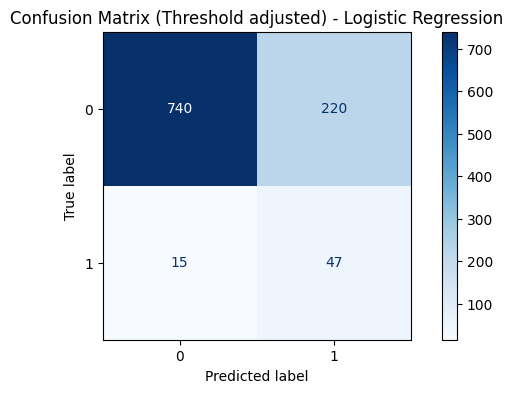

In [10]:
# Evaluate the model
print(classification_report(y_test, y_pred_new))

cm2 = confusion_matrix(y_test, y_pred_new)

# Plot the confusion matrix
cmp2 = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = best_model.classes_)
fig, ax = plt.subplots(figsize = (8,4))
cmp2.plot(ax = ax, cmap = "Blues")
plt.title("Confusion Matrix (Threshold adjusted) - Logistic Regression")
plt.show()

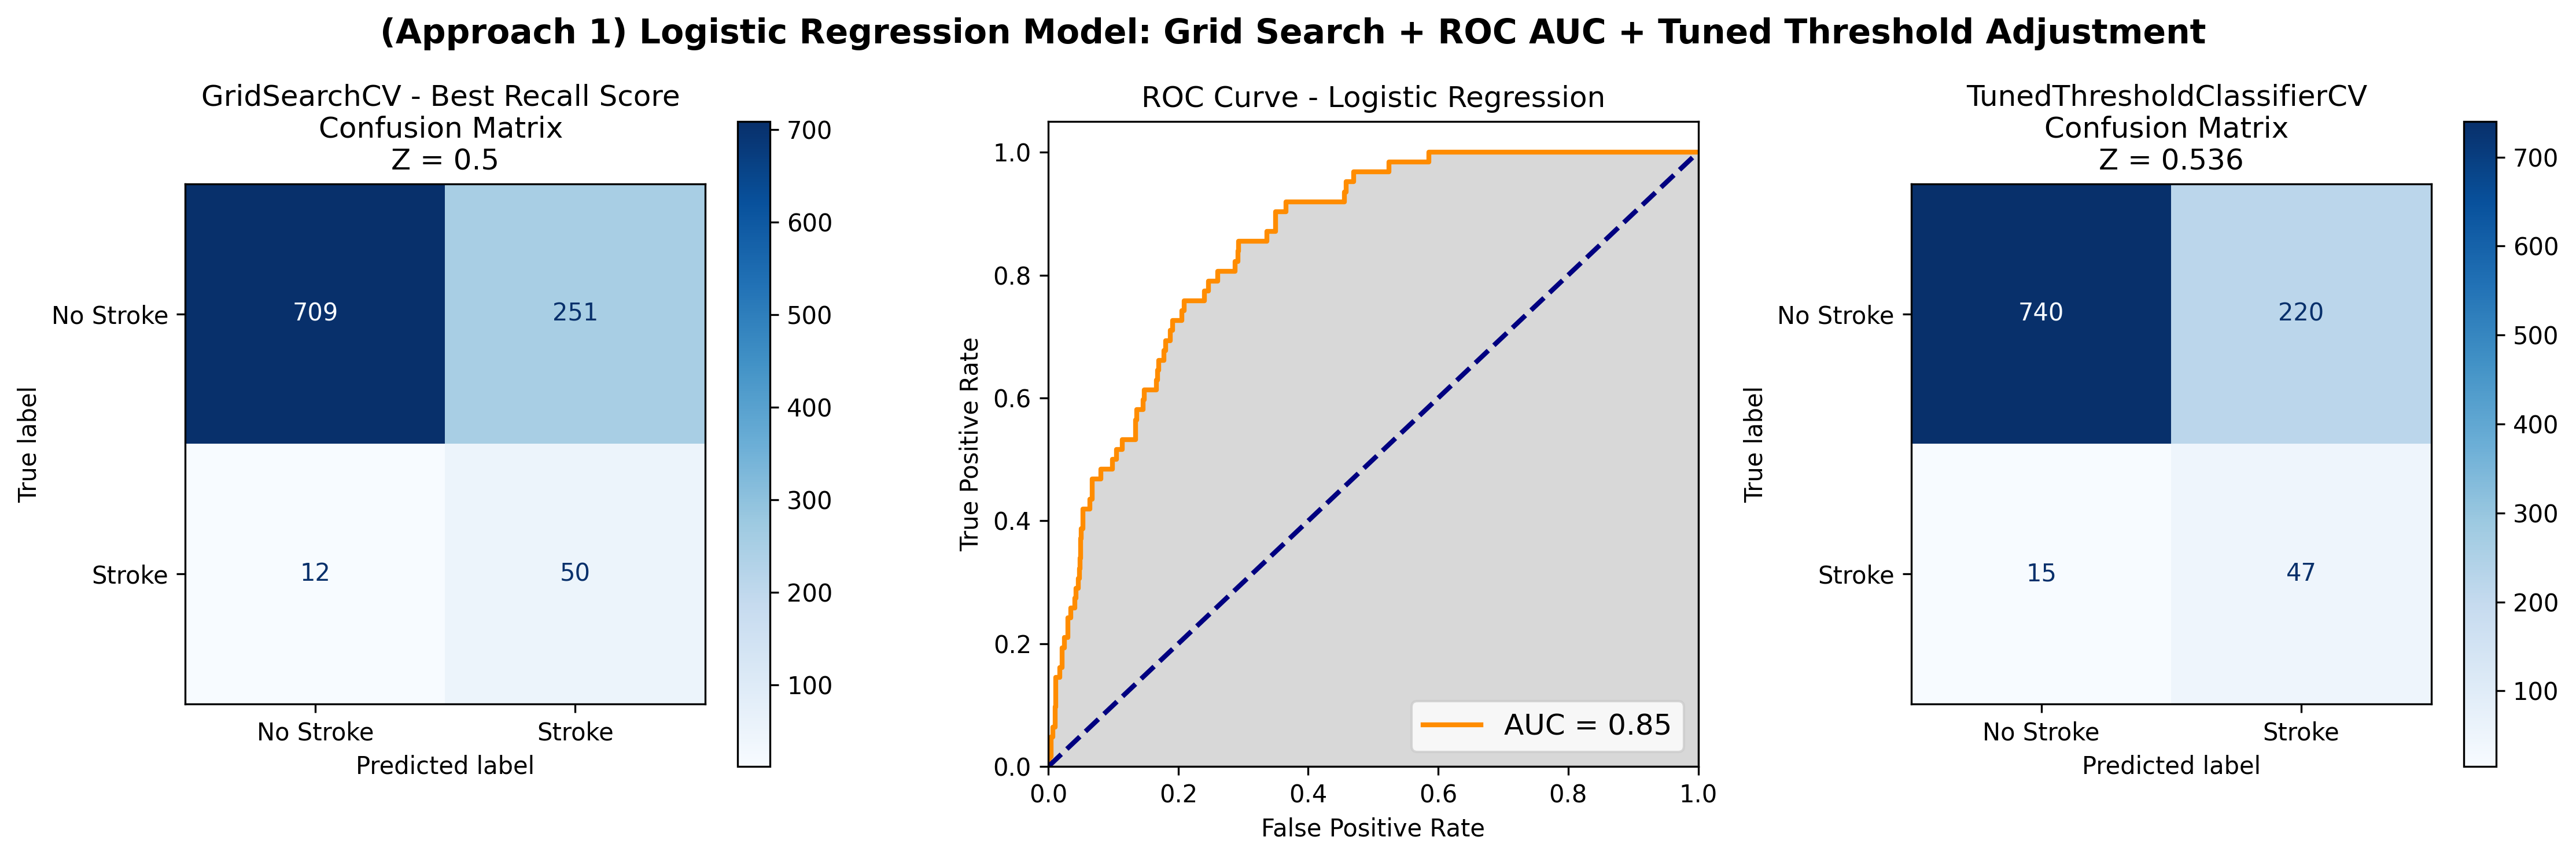

In [11]:
# Create figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize = (15, 5), dpi = 300)

# Plot first confusion matrix
cmp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["No Stroke", "Stroke"])
cmp1.plot(ax=axes[0], cmap="Blues")
axes[0].set_title("GridSearchCV - Best Recall Score \nConfusion Matrix \nZ = 0.5")

# Plot ROC curve in the second subplot
axes[1].plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
axes[1].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
axes[1].fill_between(fpr, tpr, color="gray", alpha=0.3)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve - Logistic Regression")
axes[1].legend(loc="lower right", fontsize=12)

# Plot second confusion matrix
cmp2 = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ["No Stroke", "Stroke"])
cmp2.plot(ax=axes[2], cmap="Blues")
axes[2].set_title(f"TunedThresholdClassifierCV \nConfusion Matrix \nZ = {classifier_tuned.best_threshold_:.3f}")

# Add a super title
fig.suptitle("(Approach 1) Logistic Regression Model: Grid Search + ROC AUC + Tuned Threshold Adjustment", fontsize = 14, fontweight = "bold")

# Adjust layout
plt.tight_layout()
plt.show()

## Define model parameters to use in `GridSearchCV` to find optimal parameters for `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier` and `XGBClassifier`

In [12]:
# Define model parameters as nested dictionary
model_params = {
    "Logistic Regression": {
        "model": LogisticRegression(solver = "saga", penalty = "elasticnet", random_state = STATE_NUM, max_iter = 1000, class_weight = "balanced"),
        "params": {
            "C": [0.01, 0.1, 1.0],
            "l1_ratio": np.arange(0, 1.1, 0.1)
        }
    },
    "Decision Tree Classifier": {
        "model": DecisionTreeClassifier(random_state = STATE_NUM, class_weight = "balanced"),
        "params": {
            "max_depth": [5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "Random Forest Classifier": {
        "model": RandomForestClassifier(random_state = STATE_NUM, n_jobs = -1, class_weight = "balanced"),
        "params": {
            "n_estimators": [100, 300],  
            "max_depth": [10, 20],
            "min_samples_leaf": [1, 2, 4],
            "min_samples_split": [2, 5]
        }
    },
    "XGBoost Classifier": {
        "model": XGBClassifier(random_state = STATE_NUM, n_jobs = -1),
        "params": {
            "n_estimators": [100, 300, 500], 
            "max_depth": [3, 4, 5],
            "learning_rate": [0.01, 0.05, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "scale_pos_weight": [19]
        }
    }
}

## Create function to explore a variety of models, plot confusion matrix and the ROC-AUC curve, and return relevant metrics

### Model Evaluation Pipeline Summary

This function evaluates machine learning models through `GridSearchCV` and `TunedThresholdClassifierCV` with the following key steps:

1. **Initial Model Fitting**: 
   - `GridSearchCV` is used to find the best model by tuning hyperparameters and refitting based on **recall score** as we want to maximize the number of true positives and avoiding false negatives is more important for our business problem than avoiding false positives.
   - $\text{Recall} = \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}$
   - We also consider other relevant model evaluation metrics, such as **ROC AUC score**, **accuracy**, and **f1 score**.
  
2. **ROC AUC Calculation**: 
   - The **ROC curve** is plotted, and the **AUC** is calculated to evaluate model performance.

3. **Threshold Tuning**: 
   - The `TunedThresholdClassifierCV` optimizes the decision threshold for improved balanced accuracy.
   - The best threshold is identified and used to adjust predictions. This usually slightly improve the specificity ($\frac{\text{TN}}{\text{TN} + \text{FP}}$) of the model while not compromising too much on recall.

4. **Confusion Matrices**: 
   - **Initial and modified confusion matrices** are plotted for comparison.
   - Subplots show the grid search confusion matrix, ROC curve, and tuned threshold confusion matrix.

5. **Metrics Comparison**: 
   - Displays performance metrics for both the initial and modified thresholds: **recall**, **f1 score**, and **accuracy**.

6. **Visualization**:
   - **ROC curve** with shaded area under the curve. (No change after threshold modification)
   - **Confusion matrices** displayed show the changes to the confusion matrix after threshold modification.

7. **Results**:
   - A summary dataframe with the best models, parameters, and metrics is returned for further analysis.

### Key Outputs:
- Best model selection via `GridSearchCV`.
- Optimal threshold after **threshold tuning**.
- Detailed metrics: **ROC AUC**, **recall**, **f1 score**, and **accuracy**.
- Plots of confusion matrices and ROC curves for visual evaluation.

This process allows for comprehensive model comparison, evaluation, and threshold optimization.

In [13]:
def evaluate_best_model(param_grid, cv_splits, X_train, X_test, y_train, y_test, cm_palette):
    # Store final results
    scores = []

    # Loop to find the optimal algorithm for each machine learning algorithm
    for model_name, mp in param_grid.items():
        clf = GridSearchCV(
            estimator = mp["model"], 
            param_grid = mp["params"], 
            scoring = {
                "roc_auc_score": make_scorer(roc_auc_score),
                "accuracy": make_scorer(accuracy_score), 
                "f1_score": make_scorer(f1_score),
                "recall_score": make_scorer(recall_score),
            },
            cv = CV_SPLITS, 
            return_train_score = False,
            refit = "recall_score", # Can refit to select which scoring metric is most important (will be used to obtain best_estimator_)
            n_jobs = -1
        )
        clf.fit(X_train, y_train)

        ### PART 1: FINDING THE INITIAL BEST MODEL ###

        # Get best estimator based on highest recall score (refit parameter in GridSearchCV)
        best_model = clf.best_estimator_
        
        # Obtain average amount of time for fitting the training data using this model
        mean_fit_time = clf.cv_results_["mean_fit_time"][clf.best_index_]

        ### PART 2: CALCULATING ROC AUC SCORE ###

        # Predict discrete values and probabilities on the test set
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] # Need for AUC        

        # Calculate the ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr) # Should be same value as ROC AUC score

        # Verify AUC score is the same
        test_roc_auc = roc_auc_score(y_test, y_prob)

        ### PART 3: TUNING THE THRESHOLD ###

        # With cross-validation for threshold tuning (only on training set to avoid overfitting)
        classifier_tuned = TunedThresholdClassifierCV(best_model, scoring = "balanced_accuracy", cv = cv_splits).fit(X_train, y_train)
        
        # Get predicted probabilities for the positive class
        y_probs = best_model.predict_proba(X_test)[:, 1]

        # Adjust the threshold based on tuned classifier
        threshold = classifier_tuned.best_threshold_
        y_pred_new = (y_probs >= threshold).astype(int)

        # Print initial test scores and test scores with modified threshold based on tuned classifier
        test_rec_score, test_f1_score, test_acc_score, = recall_score(y_test, y_pred), f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)
        mod_rec_score, mod_f1_score, mod_acc_score, = recall_score(y_test, y_pred_new), f1_score(y_test, y_pred_new), accuracy_score(y_test, y_pred_new)

        # Print key metrics
        print(f"For {model_name}:\n")
        print(f"Best Model (highest recall)   : {best_model}\n")
        print(f"Average Fit Time (seconds)    : {round(mean_fit_time, 4)}")
        print(f"Test ROC AUC Score            : {round(test_roc_auc, 4)}")
        print(f"Optimally-tuned Threshold     : {round(classifier_tuned.best_threshold_, 4)}")
        print(f"Test (Modified) Recall Score  : {round(test_rec_score, 4)} ({round(mod_rec_score, 4)})")
        print(f"Test (Modified) F1 Score      : {round(test_f1_score, 4)} ({round(mod_f1_score, 4)})")
        print(f"Test (Modified) Accuracy Score: {round(test_acc_score, 4)} ({round(mod_acc_score, 4)})")

        # Below section is just for checking the score values using the classification report, can comment out if unnecessary
        # # Get classification report results
        # print("Initial Classifcation Report")
        # print(classification_report(y_test, y_pred))
        # # Get post-threshold adjustment report results
        # print("Adjusted Classification Report")
        # print(classification_report(y_test, y_pred_new))

        ### PART 4: PLOTTING ALL FINDINGS ###

        # Plot the confusion matrix using the best model from the initial grid search, the ROC curve, and the post-theshold tuning confusion matrix
        cm1 = confusion_matrix(y_test, y_pred)
        cm2 = confusion_matrix(y_test, y_pred_new)

        # Create figure with 3 subplots (1 row, 3 columns)
        fig, axes = plt.subplots(1, 3, figsize = (15, 5), dpi = 300)

        # Plot first confusion matrix
        cmp1 = ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = ["No Stroke", "Stroke"])
        cmp1.plot(ax = axes[0], cmap = cm_palette)
        axes[0].set_title("GridSearchCV - Best Recall Score \nConfusion Matrix \nZ = 0.5000")

        # Plot ROC curve in the second subplot
        axes[1].plot(fpr, tpr, color = "darkorange", lw = 2, label = f"AUC = {roc_auc:.2f}")
        axes[1].plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
        axes[1].fill_between(fpr, tpr, color = "gray", alpha = 0.3)
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].set_title(f"ROC Curve - {model_name}")
        axes[1].legend(loc = "lower right", fontsize = 12)

        # Plot second confusion matrix
        cmp2 = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ["No Stroke", "Stroke"])
        cmp2.plot(ax = axes[2], cmap = cm_palette)
        axes[2].set_title(f"TunedThresholdClassifierCV \nConfusion Matrix \nZ = {classifier_tuned.best_threshold_:.4f}")

        # Set approach number based on palette color of confusion matrix
        display_text = {"Blues": 1, "Purples": 2}
        approach_num = display_text[cm_palette] 

        # Add a super title
        fig.suptitle(f"Approach {approach_num} - {model_name} Model: Grid Search + ROC AUC + Tuned Threshold Adjustment", fontsize = 14, fontweight = "bold")

        # Adjust layout
        plt.tight_layout()
        plt.show()

        ### PART 5: RETURNING ALL PARAMETERS AND METRICS FOR ANALYSIS ###

        # Append best model parameters to list
        scores.append({
            "model_name": model_name,
            "best_algorithm": best_model,
            "mean_fit_time": mean_fit_time,
            "roc_auc_score": test_roc_auc,
            "test_recall_score": test_rec_score,
            "test_f1_score": test_f1_score,
            "test_acc_score": test_acc_score,
            "mod_recall_score": mod_rec_score,
            "mod_f1_score": mod_f1_score,
            "mod_acc_score": mod_acc_score,            
        })

    # Store best models in dataframe
    score_df = pd.DataFrame(scores, columns = scores[0].keys())
    score_df.set_index("model_name", inplace = True)
    score_df.index.name = None  # Remove the name of the index
    
    return score_df

## **Approach 1**: Use all features

In [14]:
# Split into features and target
X = df.drop("stroke", axis = 1, inplace = False)
X["avg_glucose_level"] = np.log(X["avg_glucose_level"]) # Log transform for better normalization
y = df["stroke"]

# Perform train test split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = T_SIZE, random_state = STATE_NUM)

# Scale data after train-test split to avoid data leakage
scaler = StandardScaler()
X_train[NUMERIC_FEATURES] = scaler.fit_transform(X_train[NUMERIC_FEATURES])
X_test[NUMERIC_FEATURES] = scaler.transform(X_test[NUMERIC_FEATURES])

For Logistic Regression:

Best Model (highest recall)   : LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=0.0, max_iter=1000,
                   penalty='elasticnet', random_state=42, solver='saga')

Average Fit Time (seconds)    : 0.0454
Test ROC AUC Score            : 0.8516
Optimally-tuned Threshold     : 0.5359
Test (Modified) Recall Score  : 0.8065 (0.7581)
Test (Modified) F1 Score      : 0.2755 (0.2857)
Test (Modified) Accuracy Score: 0.7427 (0.7701)


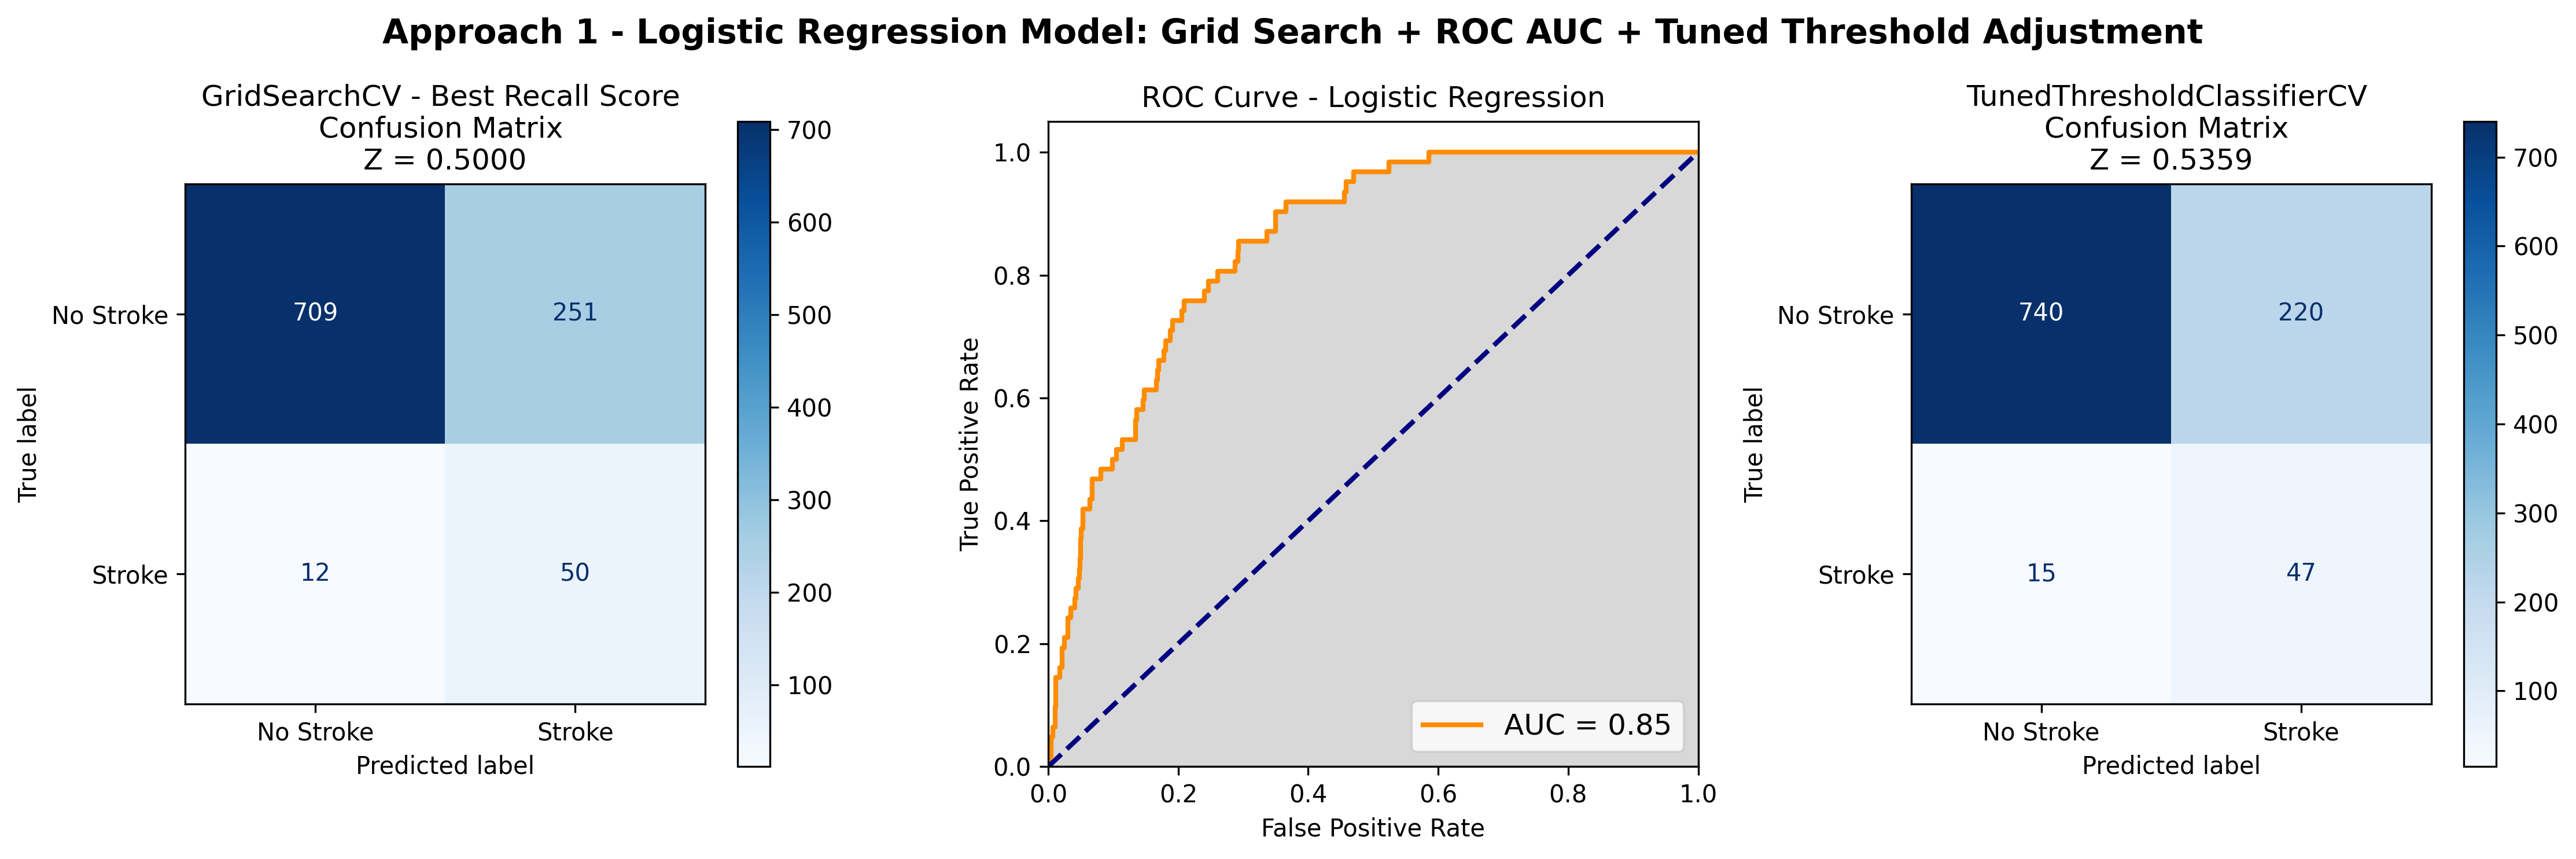

For Decision Tree Classifier:

Best Model (highest recall)   : DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

Average Fit Time (seconds)    : 0.0259
Test ROC AUC Score            : 0.7946
Optimally-tuned Threshold     : 0.6869
Test (Modified) Recall Score  : 0.6452 (0.6452)
Test (Modified) F1 Score      : 0.2712 (0.2996)
Test (Modified) Accuracy Score: 0.7896 (0.817)


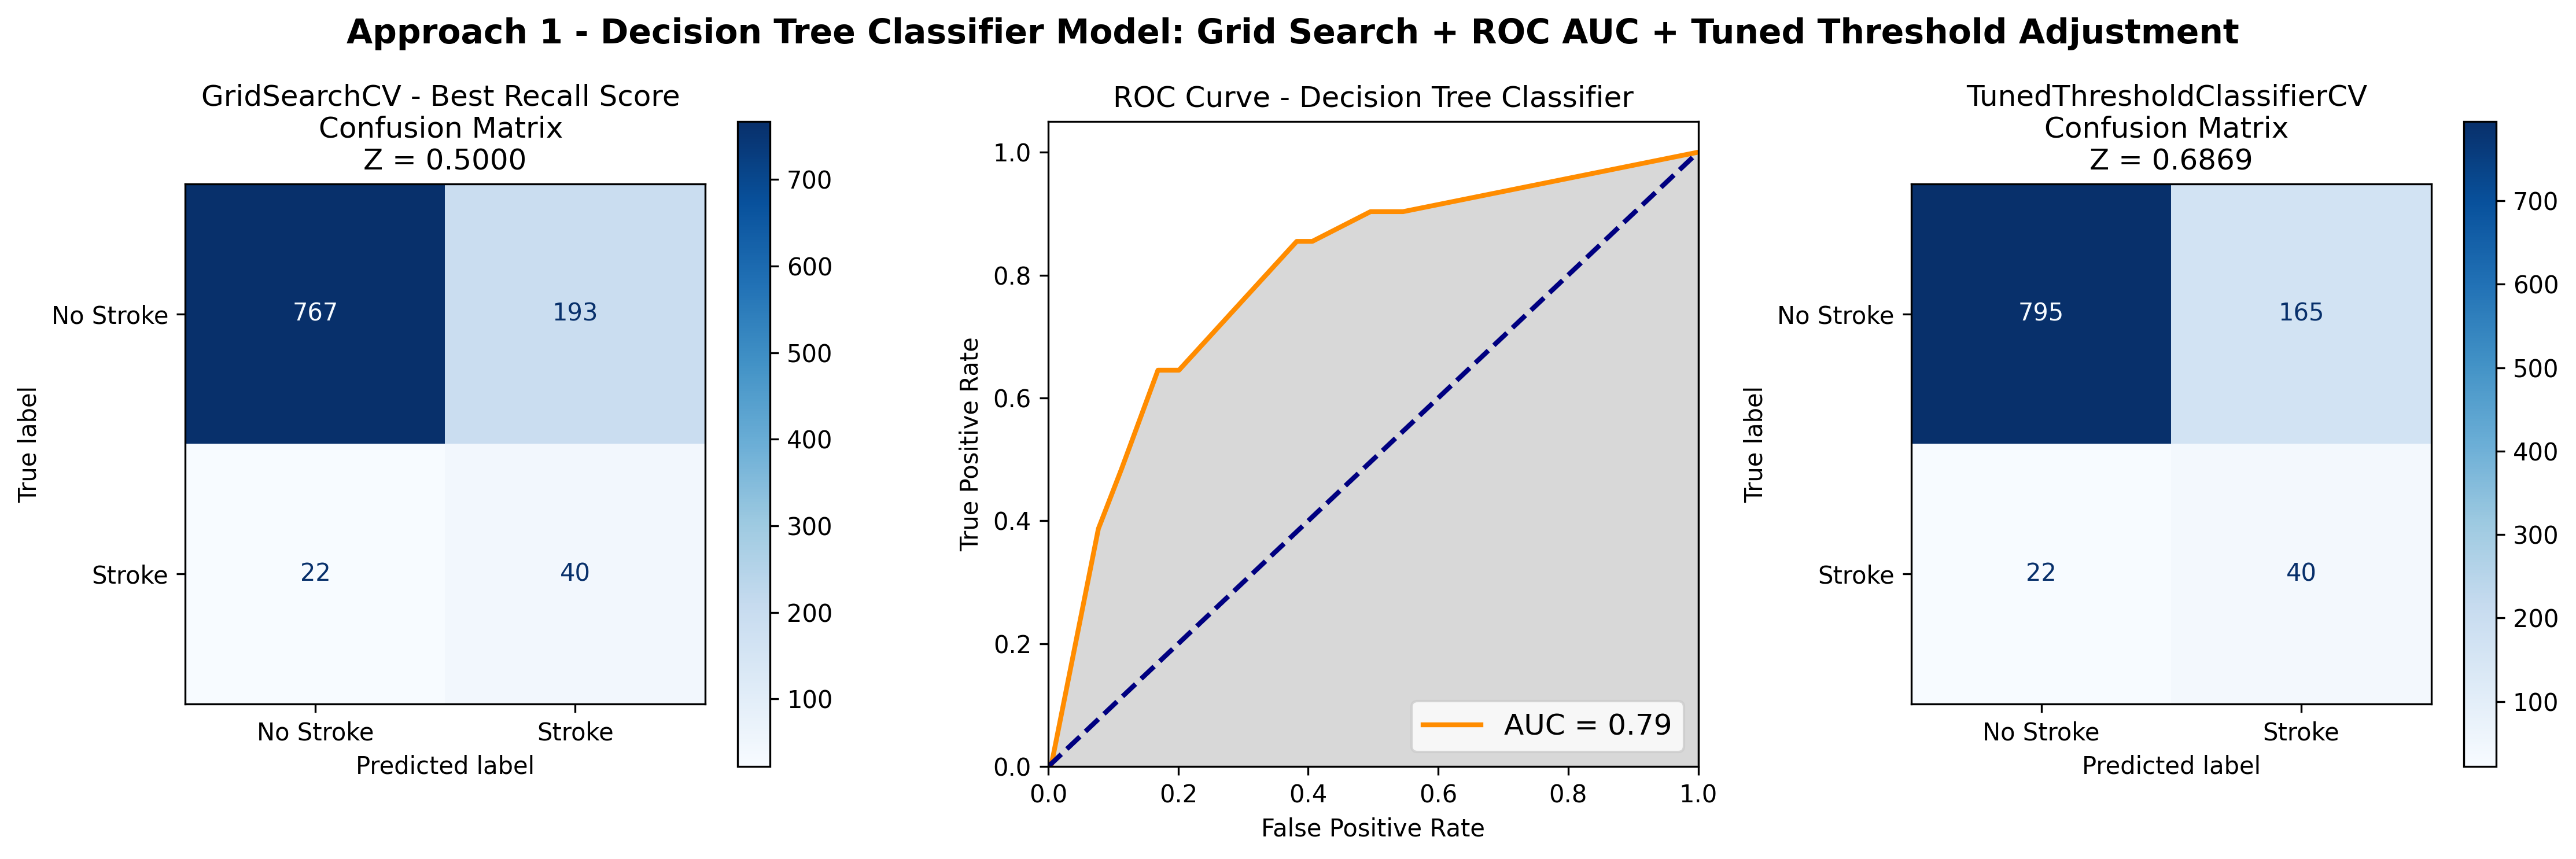

For Random Forest Classifier:

Best Model (highest recall)   : RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, n_estimators=300, n_jobs=-1,
                       random_state=42)

Average Fit Time (seconds)    : 5.3467
Test ROC AUC Score            : 0.8473
Optimally-tuned Threshold     : 0.2411
Test (Modified) Recall Score  : 0.3065 (0.8548)
Test (Modified) F1 Score      : 0.2517 (0.2865)
Test (Modified) Accuracy Score: 0.8894 (0.7417)


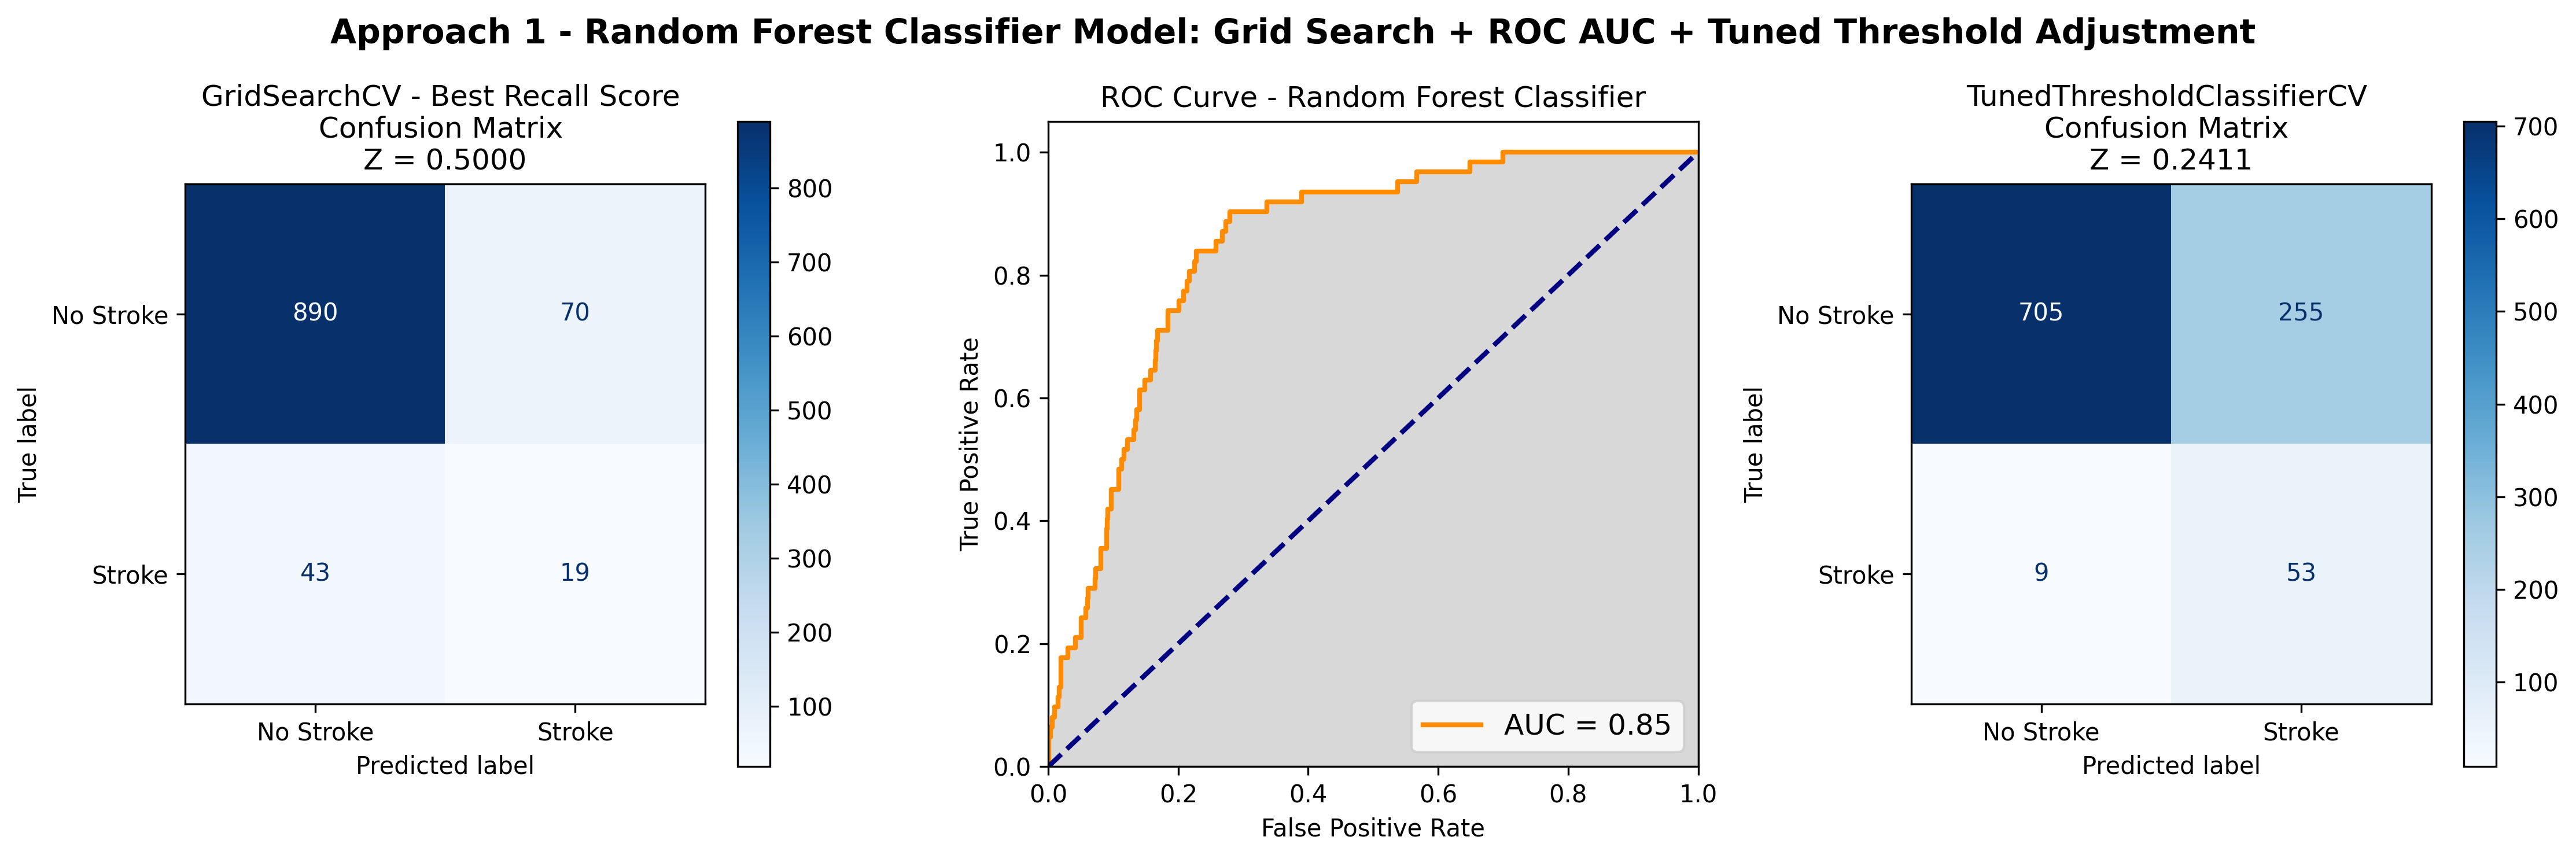

For XGBoost Classifier:

Best Model (highest recall)   : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

Average Fit Time (seconds)    : 0.1869
Test ROC AUC Score            : 0.841
Optimally-tuned Threshold     : 0.4916
Test (Modified) Recall Score  : 0.7419 (0.7419)
Test (Modified) F1 Score     

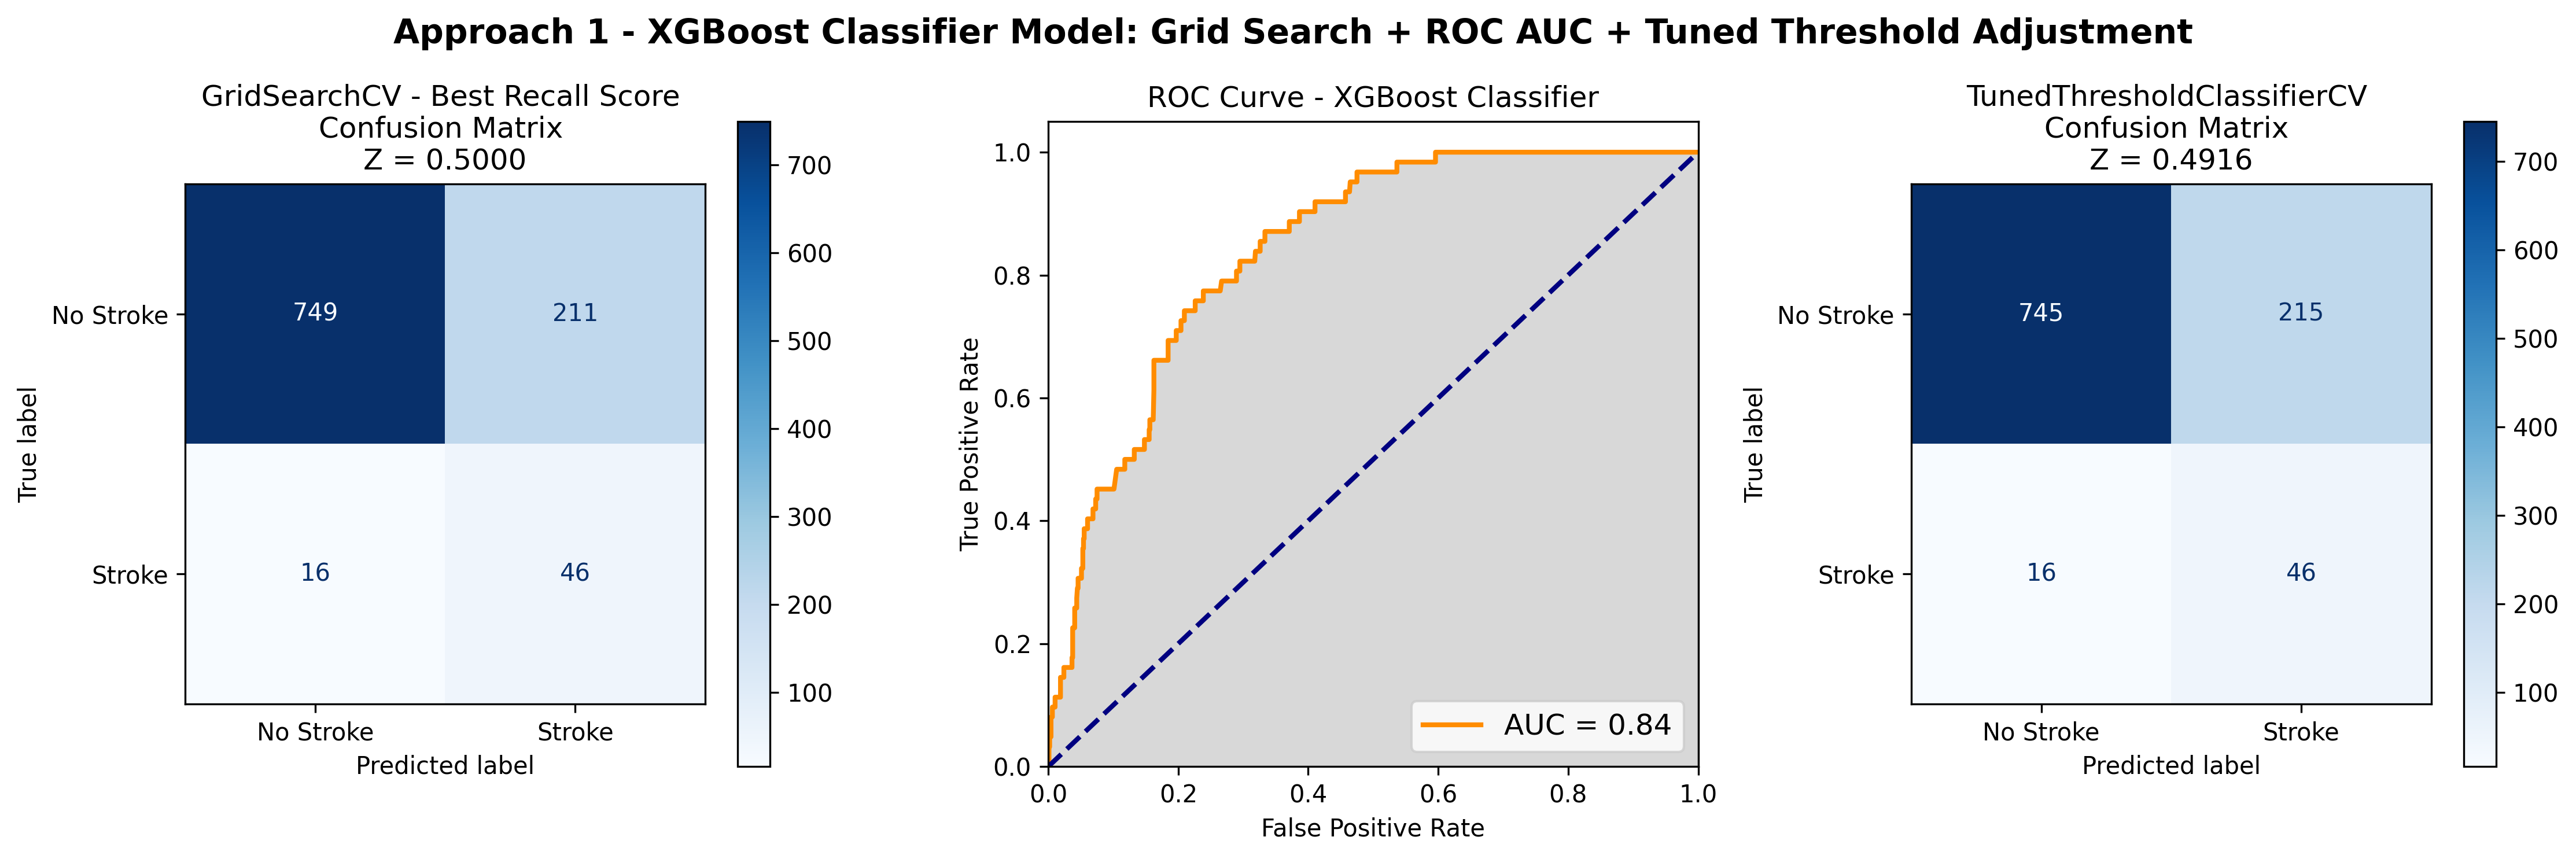

,best_algorithm,mean_fit_time,roc_auc_score,test_recall_score,test_f1_score,test_acc_score,mod_recall_score,mod_f1_score,mod_acc_score
Logistic Regression,"LogisticRegression(C=0.01, class_weight='balan...",0.045450,0.851562,0.806452,0.275482,0.742661,0.758065,0.285714,0.770059
Decision Tree Classifier,DecisionTreeClassifier(class_weight='balanced'...,0.025940,0.794640,0.645161,0.271186,0.789628,0.645161,0.299625,0.817025
Random Forest Classifier,"(DecisionTreeClassifier(max_depth=10, max_feat...",5.346738,0.847278,0.306452,0.251656,0.889432,0.854839,0.286486,0.741683
XGBoost Classifier,"XGBClassifier(base_score=None, booster=None, c...",0.186923,0.841045,0.741935,0.288401,0.777886,0.741935,0.284830,0.773973


In [15]:
# Call function for approach 1
approach1_df = evaluate_best_model(model_params, CV_SPLITS, X_train, X_test, y_train, y_test, "Blues")
approach1_df

## **Approach 2**: Use only health-related features

In [16]:
# Split into selected features and target
X = df.drop(["stroke", "ever_married_yes", "employment_status_unemployed", "residence_type_urban"], axis = 1, inplace = False)
X["avg_glucose_level"] = np.log(X["avg_glucose_level"]) # Log transform for better normalization
y = df["stroke"]

# Perform train test split again
X_train_health, X_test_health, y_train_health, y_test_health = train_test_split(X, y, test_size = T_SIZE, random_state = STATE_NUM)

# Scale data after train-test split to avoid data leakage
scaler = StandardScaler()
X_train_health[NUMERIC_FEATURES] = scaler.fit_transform(X_train_health[NUMERIC_FEATURES])
X_test_health[NUMERIC_FEATURES] = scaler.transform(X_test_health[NUMERIC_FEATURES])

For Logistic Regression:

Best Model (highest recall)   : LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=0.0, max_iter=1000,
                   penalty='elasticnet', random_state=42, solver='saga')

Average Fit Time (seconds)    : 0.0366
Test ROC AUC Score            : 0.8518
Optimally-tuned Threshold     : 0.5434
Test (Modified) Recall Score  : 0.8065 (0.7581)
Test (Modified) F1 Score      : 0.2762 (0.2892)
Test (Modified) Accuracy Score: 0.7436 (0.774)


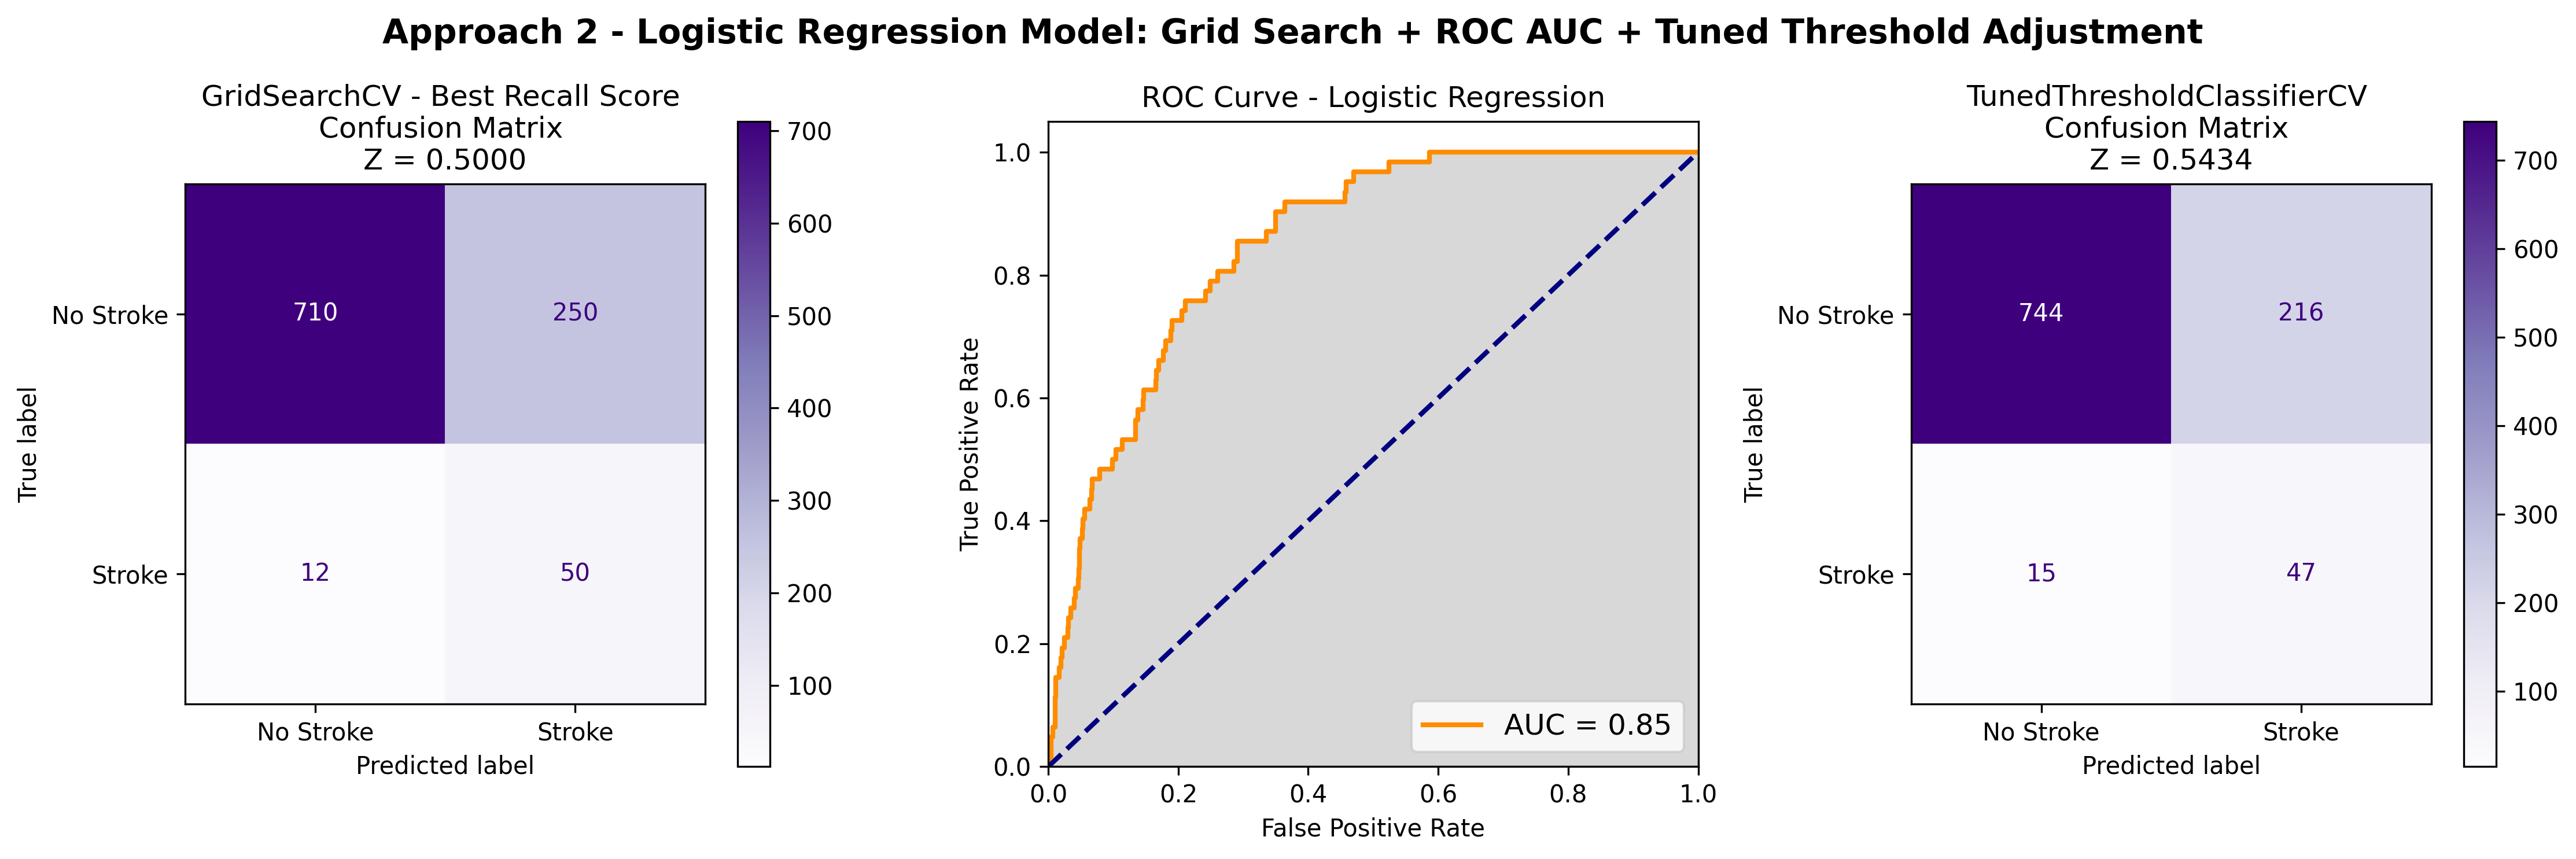

For Decision Tree Classifier:

Best Model (highest recall)   : DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

Average Fit Time (seconds)    : 0.0205
Test ROC AUC Score            : 0.7946
Optimally-tuned Threshold     : 0.6869
Test (Modified) Recall Score  : 0.6452 (0.6452)
Test (Modified) F1 Score      : 0.2712 (0.2996)
Test (Modified) Accuracy Score: 0.7896 (0.817)


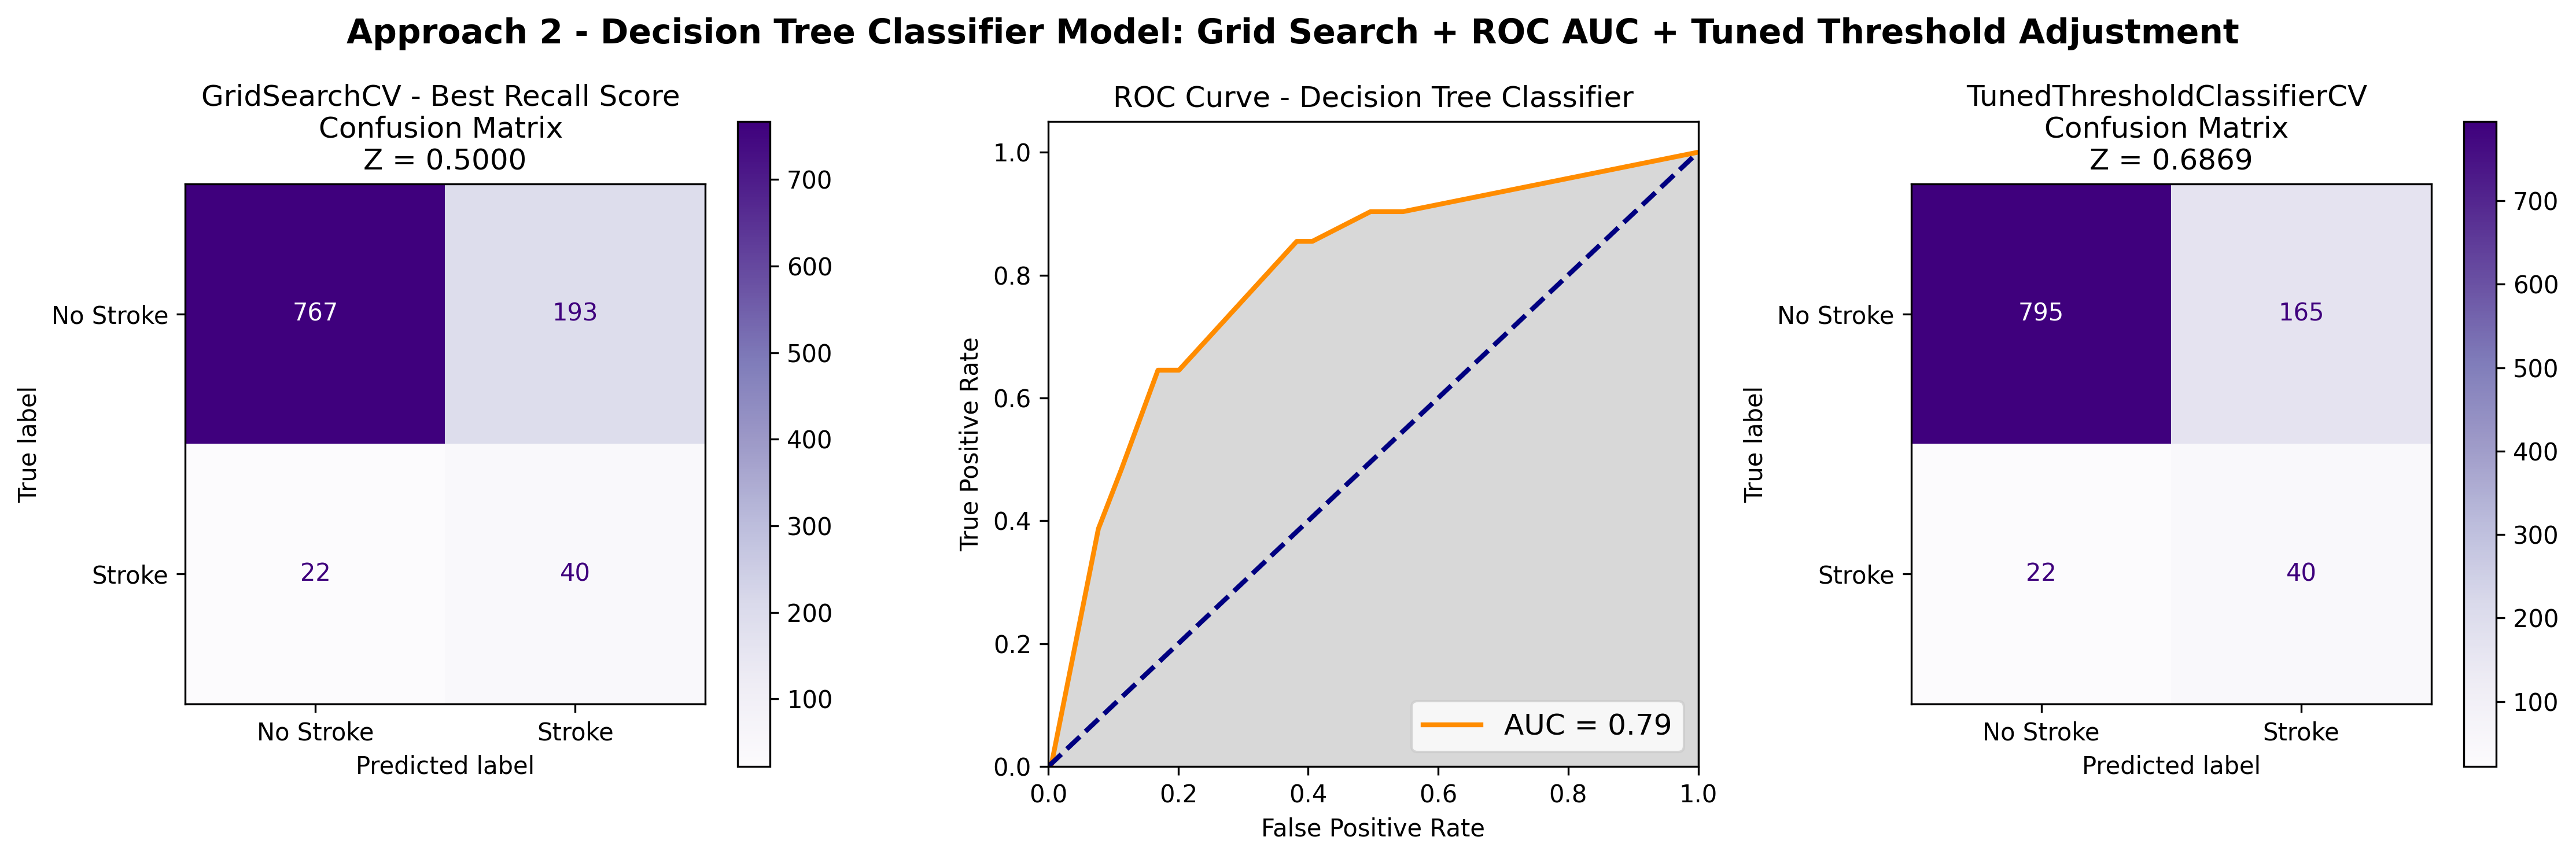

For Random Forest Classifier:

Best Model (highest recall)   : RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, n_estimators=300, n_jobs=-1,
                       random_state=42)

Average Fit Time (seconds)    : 2.9056
Test ROC AUC Score            : 0.8446
Optimally-tuned Threshold     : 0.1454
Test (Modified) Recall Score  : 0.2581 (0.9032)
Test (Modified) F1 Score      : 0.2192 (0.2363)
Test (Modified) Accuracy Score: 0.8885 (0.6458)


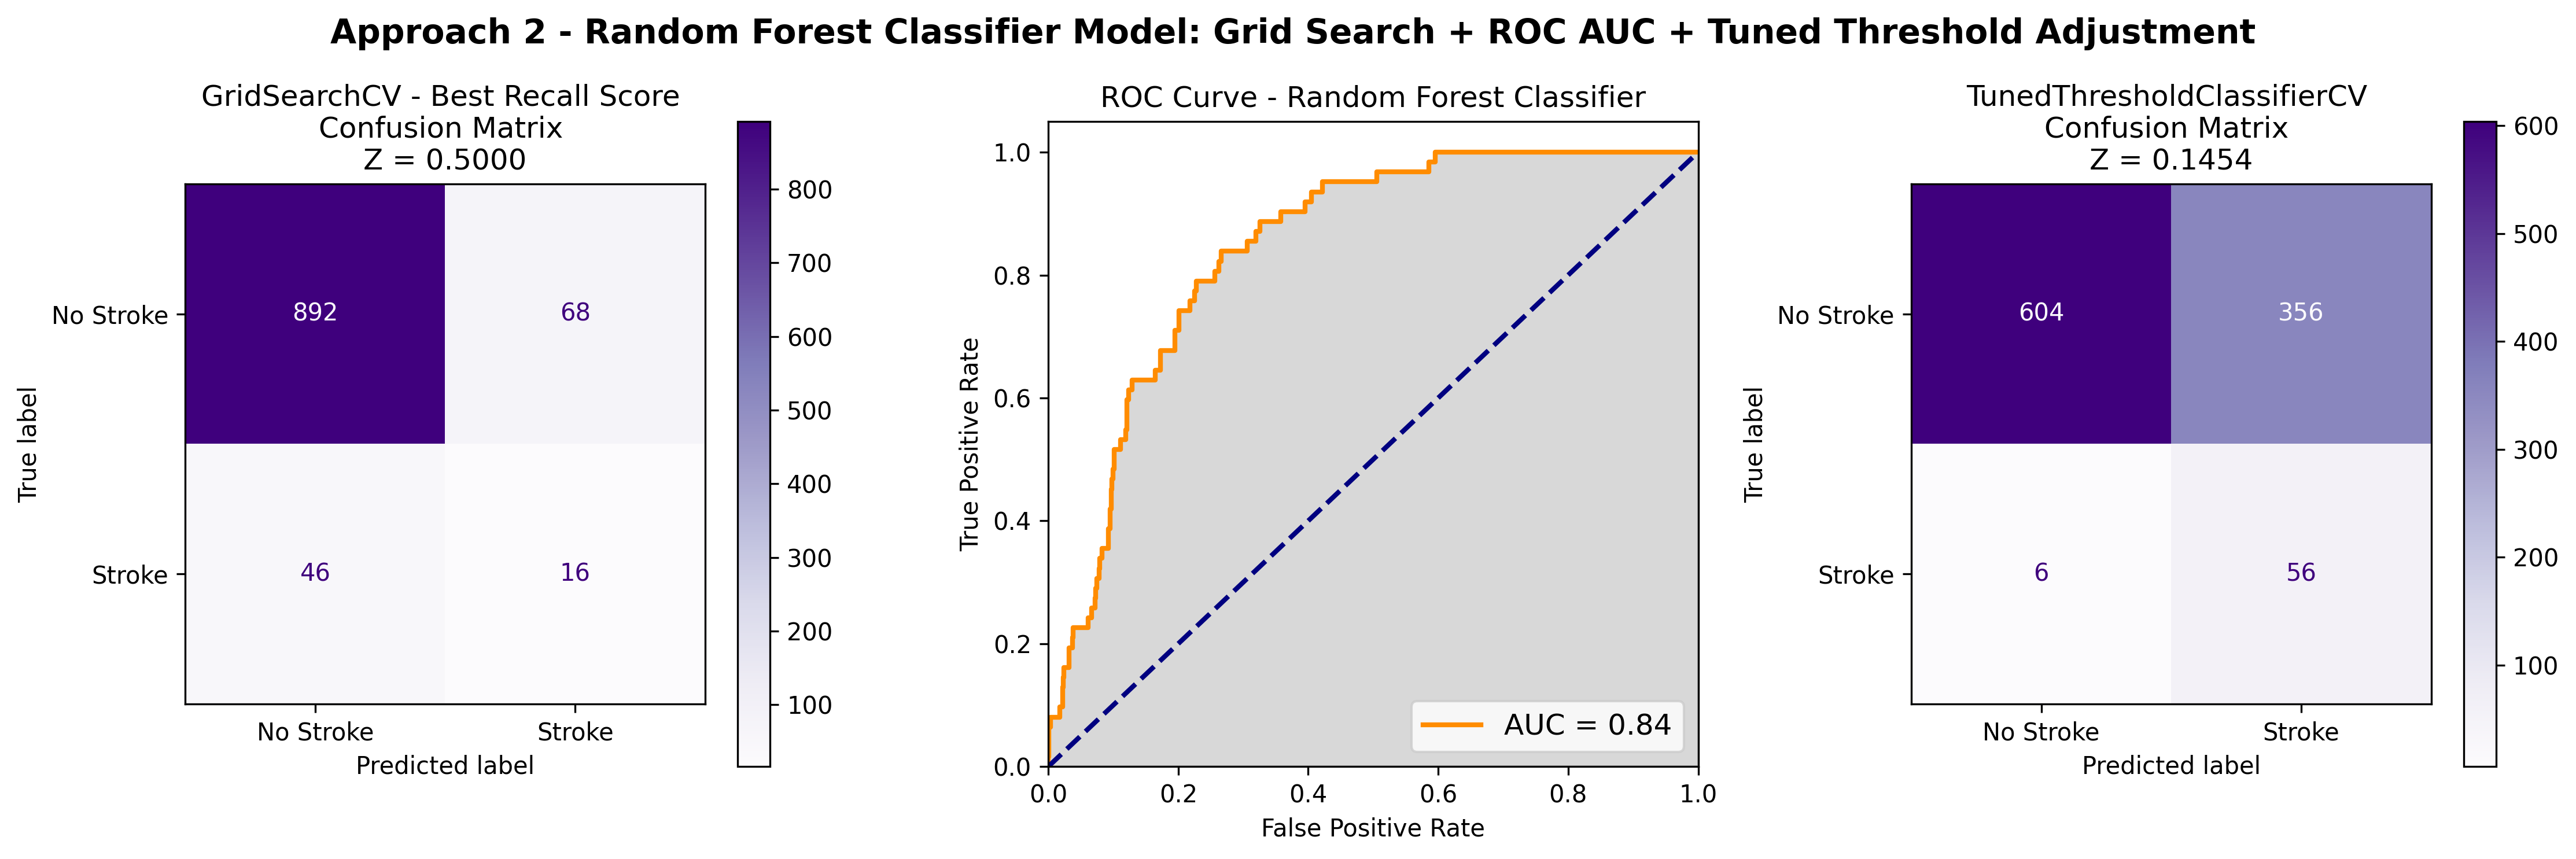

For XGBoost Classifier:

Best Model (highest recall)   : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

Average Fit Time (seconds)    : 0.6685
Test ROC AUC Score            : 0.8469
Optimally-tuned Threshold     : 0.4909
Test (Modified) Recall Score  : 0.7258 (0.7258)
Test (Modified) F1 Score    

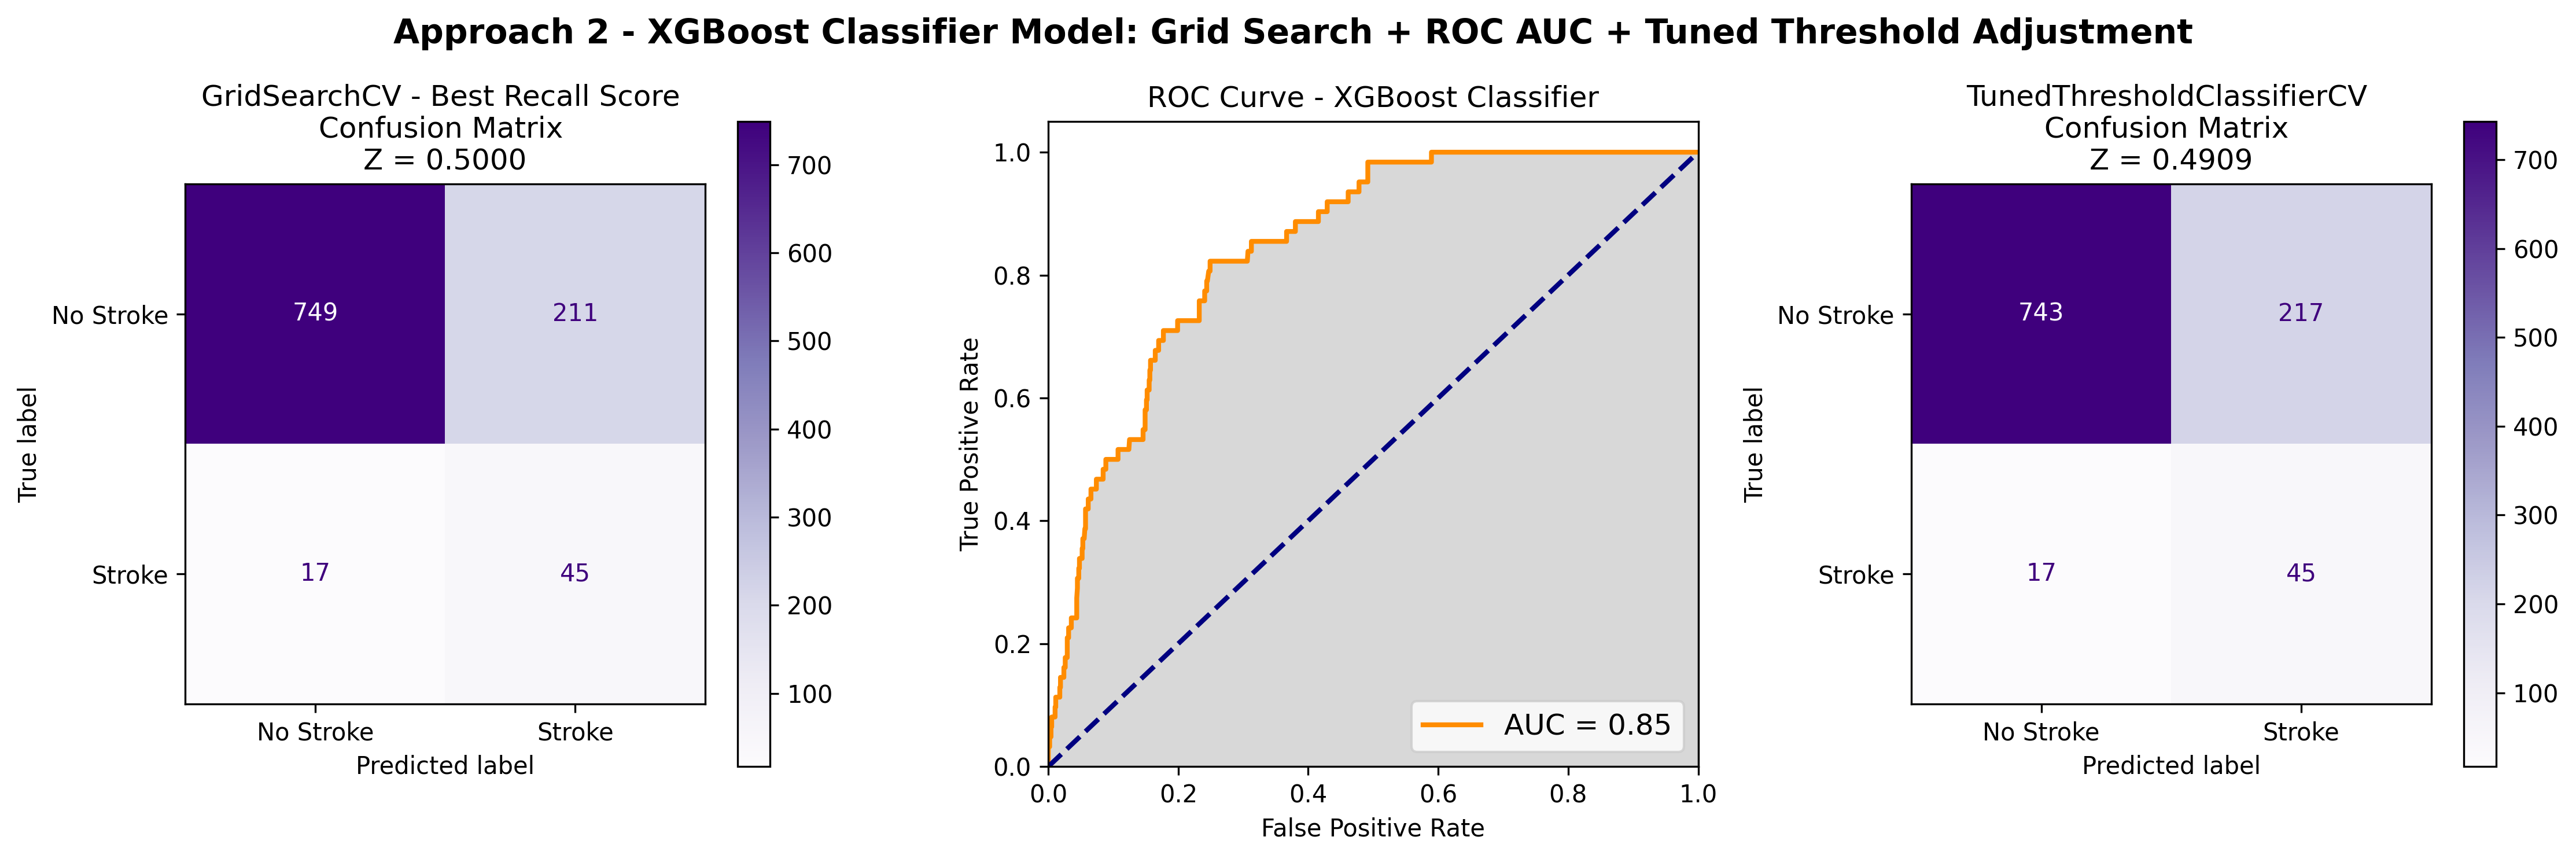

,best_algorithm,mean_fit_time,roc_auc_score,test_recall_score,test_f1_score,test_acc_score,mod_recall_score,mod_f1_score,mod_acc_score
Logistic Regression,"LogisticRegression(C=0.01, class_weight='balan...",0.036586,0.851798,0.806452,0.276243,0.743640,0.758065,0.289231,0.773973
Decision Tree Classifier,DecisionTreeClassifier(class_weight='balanced'...,0.020503,0.794640,0.645161,0.271186,0.789628,0.645161,0.299625,0.817025
Random Forest Classifier,"(DecisionTreeClassifier(max_depth=10, max_feat...",2.905645,0.844640,0.258065,0.219178,0.888454,0.903226,0.236287,0.645793
XGBoost Classifier,"XGBClassifier(base_score=None, booster=None, c...",0.668512,0.846925,0.725806,0.283019,0.776908,0.725806,0.277778,0.771037


In [17]:
# Call function for approach 2
approach2_df = evaluate_best_model(model_params, CV_SPLITS, X_train_health, X_test_health, y_train_health, y_test_health, "Purples")
approach2_df

## Model Comparison

In [18]:
# View stored results in a MultiIndex DataFrame
result = pd.concat([approach1_df, approach2_df], keys = ["Approach 1: All features", "Approach 2: Health-related features only"])
result.columns = pd.MultiIndex.from_tuples([
    ("Model Details", "best_algorithm"),
    ("Model Details", "mean_fit_time"),
    ("Model Details", "roc_auc_score"),
    ("Baseline Metrics", "test_recall_score"),
    ("Baseline Metrics", "test_f1_score"),
    ("Baseline Metrics", "test_acc_score"),
    ("Post-Tuning Metrics", "mod_recall_score"),
    ("Post-Tuning Metrics", "mod_f1_score"),
    ("Post-Tuning Metrics", "mod_acc_score")
])
result

Model Details  \
                                                                                                      best_algorithm   
Approach 1: All features                 Logistic Regression       LogisticRegression(C=0.01, class_weight='balan...   
                                         Decision Tree Classifier  DecisionTreeClassifier(class_weight='balanced'...   
                                         Random Forest Classifier  (DecisionTreeClassifier(max_depth=10, max_feat...   
                                         XGBoost Classifier        XGBClassifier(base_score=None, booster=None, c...   
Approach 2: Health-related features only Logistic Regression       LogisticRegression(C=0.01, class_weight='balan...   
                                         Decision Tree Classifier  DecisionTreeClassifier(class_weight='balanced'...   
                                         Random Forest Classifier  (DecisionTreeClassifier(max_depth=10, max_feat...   
                                         XGBoost Classifier        XGBClassifier(base_score=None, booster=None, c...   

                                                                                 \
                                                                  mean_fit_time   
Approach 1: All features                 Logistic Regression           0.045450   
                                         Decision Tree Classifier      0.025940   
                                         Random Forest Classifier      5.346738   
                                         XGBoost Classifier            0.186923   
Approach 2: Health-related features only Logistic Regression           0.036586   
                                         Decision Tree Classifier      0.020503   
                                         Random Forest Classifier      2.905645   
                                         XGBoost Classifier            0.668512   

                                                                                 \
                                                                  roc_auc_score   
Approach 1: All features                 Logistic Regression           0.851562   
                                         Decision Tree Classifier      0.794640   
                                         Random Forest Classifier      0.847278   
                                         XGBoost Classifier            0.841045   
Approach 2: Health-related features only Logistic Regression           0.851798   
                                         Decision Tree Classifier      0.794640   
                                         Random Forest Classifier      0.844640   
                                         XGBoost Classifier            0.846925   

                                                                   Baseline Metrics  \
                                                                  test_recall_score   
Approach 1: All features                 Logistic Regression               0.806452   
                                         Decision Tree Classifier          0.645161   
                                         Random Forest Classifier          0.306452   
                                         XGBoost Classifier                0.741935   
Approach 2: Health-related features only Logistic Regression               0.806452   
                                         Decision Tree Classifier          0.645161   
                                         Random Forest Classifier          0.258065   
                                         XGBoost Classifier                0.725806   

                                                                                 \
                                                                  test_f1_score   
Approach 1: All features                 Logistic Regression           0.275482   
                                         Decision Tree Classifier      0.271186   
                                     

## Choose model to create point system

In [19]:
# Obtain logistic regression coefficients from approach 2 (easiest interpretability)
pt_system_logreg = result.loc["Approach 2: Health-related features only"].loc["Logistic Regression"]["Model Details"]["best_algorithm"]
coefficients = pt_system_logreg.coef_.flatten()

# View coefficients of the logistic regression in ascending order
coef_series = pd.Series(coefficients, index = X_train_health.columns).sort_values(ascending = False)
coef_series

age                      1.284613
hypertension             0.295013
avg_glucose_level        0.212436
heart_disease            0.206148
smoker_status_smoker     0.102318
bmi                      0.008546
smoker_status_unknown   -0.002223
gender_male             -0.040697
smoker_status_never     -0.125790
dtype: float64

In [20]:
# Filter out coefficients below the threshold (0.20) to use in the point system scorecard
filtered_coefs = coef_series[coef_series > 0.20]
filtered_coefs

age                  1.284613
hypertension         0.295013
avg_glucose_level    0.212436
heart_disease        0.206148
dtype: float64

In [21]:
# Reverse the data transformation for the training set and use `.describe` to figure out how to scale properly
X_train_health[NUMERIC_FEATURES] = scaler.inverse_transform(X_train_health[NUMERIC_FEATURES])
X_train_health["avg_glucose_level"] = np.exp(X_train_health["avg_glucose_level"])
X_train_health.drop(["smoker_status_smoker", "bmi", "smoker_status_unknown", "gender_male", "smoker_status_never"], axis = 1, inplace = True)
X_train_health.describe()

,age,avg_glucose_level,hypertension,heart_disease
count,4088.000000,4088.000000,4088.000000,4088.000000
mean,43.304149,106.453672,0.093933,0.052838
std,22.535815,45.629802,0.291772,0.223736
min,0.160000,55.120000,0.000000,0.000000
25%,25.000000,77.190000,0.000000,0.000000
50%,45.000000,91.895000,0.000000,0.000000
75%,61.000000,114.710000,0.000000,0.000000
max,82.000000,271.740000,1.000000,1.000000


## Create point system and supplementary functions

In [22]:
def create_stroke_points_system(age_coef, hypertension_coef, glucose_coef, heart_disease_coef):
    """
    Creates stroke risk point system + risk table
    """
    # Define baselines, categories and scaling manually
    scaling_factors = {"Age": 5 * age_coef, "Glucose": 25 * glucose_coef, "Binary": 0.3}
    
    base_age = 37
    base_glucose = 90
    base_logit = -4
    global_scaling = 0.35
    max_points = 16

    age_categories = {"<30": 25, "30-44": 37, "45-60": 52.5, "61-70": 65.5, "≥71": 76.5}
    glucose_categories = {"<80": 70, "80-99": 90, "100-125": 112.5, "126-199": 162.5, "≥200": 235}

    points_system = {
        "Age": {
            cat: round((val - base_age) * age_coef / scaling_factors["Age"])
            for cat, val in age_categories.items()
        },
        "Avg Glucose mg/dL": {
            cat: round((val - base_glucose) * glucose_coef / scaling_factors["Glucose"])
            for cat, val in glucose_categories.items()
        },
        "Hypertension": {
            "No": 0,
            "Yes": round(hypertension_coef / scaling_factors["Binary"])
        },
        "Heart Disease": {
            "No": 0,
            "Yes": round(heart_disease_coef / scaling_factors["Binary"])
        },
    }

    # Create total risk table with appropriate scale
    risk_table = pd.DataFrame(index = range(-3, 17, 1), columns = ["Risk"])
    
    for points in risk_table.index:
        logit = base_logit + (global_scaling * points)
        risk = 1 / (1 + np.exp(-logit))
        risk_table.loc[points, "Risk"] = round(risk, 4)

    # Cutoff table at max_points
    risk_table = risk_table[risk_table.index <= max_points]

    return points_system, risk_table, global_scaling, base_logit


def process_input_data(age, avg_glucose_mg_dL, hypertension, heart_disease):
    age_dict = {70: "≥71", 60: "61-70", 44: "45-60", 29: "30-44", 0: "<30"}
    glu_dict = {199: "≥200", 125: "126-199", 99: "100-125", 79: "80-99", 0: "<80"}

    age_val = next((v for k, v in age_dict.items() if age > k), None)
    glu_val = next((v for k, v in glu_dict.items() if avg_glucose_mg_dL > k), None)
    hyp_val = "Yes" if hypertension == 1 else 0
    htd_val = "Yes" if heart_disease == 1 else 0

    return {"Age": age_val, "Avg Glucose mg/dL": glu_val, "Hypertension": hyp_val, "Heart Disease": htd_val}


def calculate_total_points(patient_info, points_system):
    """
    Given a patient's categorical data, calculate total risk score.
    Example:
    patient_info = {
        'Age': '61-70',
        'Avg Glucose': '126-199',
        'Hypertension': 'Yes',
        'Heart Disease': 'No'
    }
    """
    total = 0
    breakdown = {}
    for feature, value in patient_info.items():
        points = points_system[feature][value]
        breakdown[feature] = points
        total += points

    return total, breakdown

def estimate_stroke_risk(total_points, base_logit = -4, scaling = 0.35, cap_at = 16):
    """
    Map total points to stroke probability using logistic function.
    """
    capped_points = min(total_points, cap_at)
    logit = base_logit + scaling * capped_points
    risk = 1 / (1 + np.exp(-logit))
    return round(risk, 4)

def plot_risk_curve(risk_table):
    """
    Optional: plot points vs risk as a curve
    """
    plt.figure(figsize = (8, 5), dpi = 300)
    plt.plot(risk_table.index, risk_table["Risk"], marker = "o", color = "navy")
    plt.yticks(ticks = np.arange(0, 0.85, 0.1))
    plt.xticks(ticks = range(-3, 17))
    plt.title("Stroke Risk vs Total Points")
    plt.xlabel("Total Points")
    plt.ylabel("Estimated Stroke Risk")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


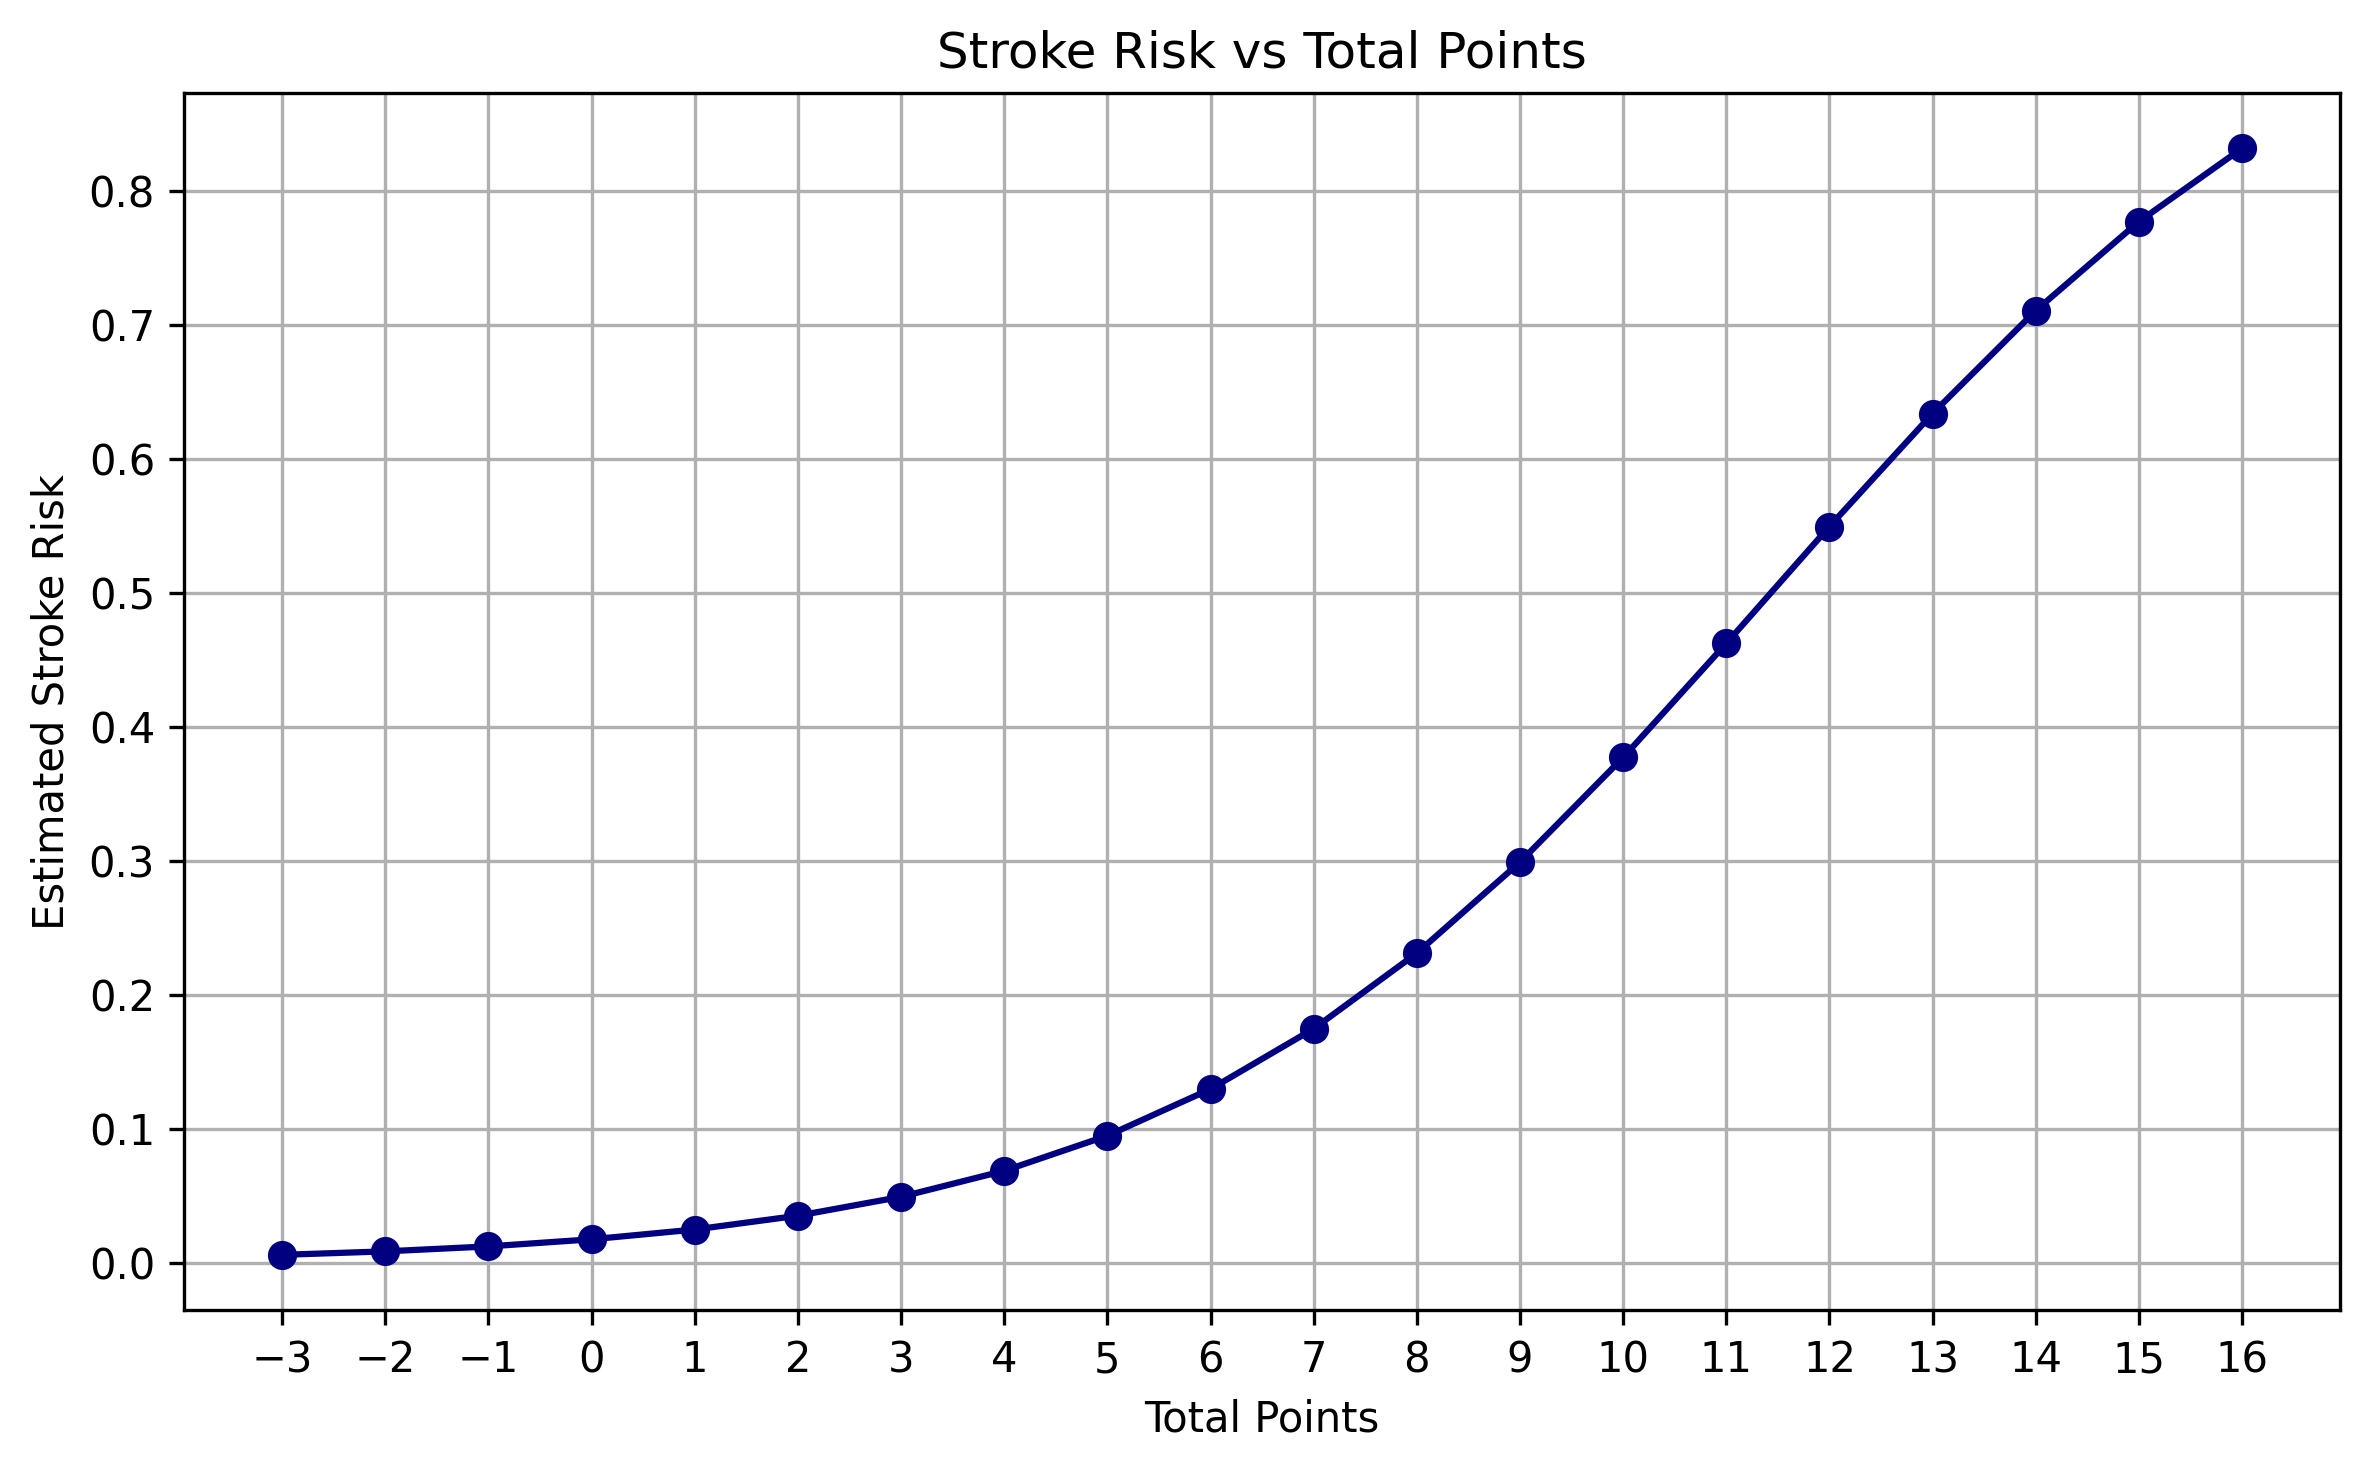

In [23]:
# Build the system
points_system, risk_table, scaling, base_logit = create_stroke_points_system(*filtered_coefs) # Unpack filtered coefficients in correct variable order
# Plot the score-to-risk curve
plot_risk_curve(risk_table)

In [24]:
# Show risk table (cutoff at maximum points available)
risk_table

,Risk
-3,0.0064
-2,0.009
-1,0.0127
0,0.018
1,0.0253
2,0.0356
3,0.0497
4,0.0691
5,0.0953
6,0.1301


In [25]:
# Show the full point system
points_system

{'Age': {'<30': -2, '30-44': 0, '45-60': 3, '61-70': 6, '≥71': 8},
 'Avg Glucose mg/dL': {'<80': -1,
  '80-99': 0,
  '100-125': 1,
  '126-199': 3,
  '≥200': 6},
 'Hypertension': {'No': 0, 'Yes': 1},
 'Heart Disease': {'No': 0, 'Yes': 1}}

## Finalised Point System for Stroke

| Variable             | Category   | Reference Value | Base Difference | Logit Units (Coefficient × Base Diff) | Points Calculation (Logit Units / Scaling Factor) | Points |
|----------------------|------------|-----------------|------------------|---------------------------------------|---------------------------------------------------|--------|
| **Age**              | <30        | 25              | 25 - 37 = -12    | -12 × 1.284613 = -15.415356          | -15.415356 ÷ (5×1.284613) = -2.4 → **-2**       | -2     |
|                      | 30-44      | 37              | 0                | 0                                     | 0 ÷ 6.423065 = 0 → **0**                         | 0      |
|                      | 45-60      | 52.5            | +15.5            | +15.5 × 1.284613 = +19.911502        | +19.911502 ÷ 6.423065 = +3.1 → **+3**           | +3     |
|                      | 61-70      | 65.5            | +28.5            | +28.5 × 1.284613 = +36.611470        | +36.611470 ÷ 6.423065 = +5.7 → **+6**           | +6     |
|                      | ≥71        | 76.5            | +39.5            | +39.5 × 1.284613 = +50.742214        | +50.742214 ÷ 6.423065 = +7.9 → **+8**           | +8     |
| **Avg Glucose mg/dL**| <80        | 70              | -20              | -20 × 0.212436 = -4.248720           | -4.248720 ÷ (25×0.212436) = -0.8 → **-1**       | -1     |
|                      | 80-99      | 90              | 0                | 0                                     | 0 ÷ 5.3109 = 0 → **0**                           | 0      |
|                      | 100-125    | 112.5           | +22.5            | +22.5 × 0.212436 = +4.779810         | +4.779810 ÷ 5.3109 = +0.9 → **+1**              | +1     |
|                      | 126-199    | 162.5           | +72.5            | +72.5 × 0.212436 = +15.401610        | +15.401610 ÷ 5.3109 = +2.9 → **+3**             | +3     |
|                      | ≥200       | 235             | +145             | +145 × 0.212436 = +30.803220         | +30.803220 ÷ 5.3109 = +5.8 → **+6**             | +6     |
| **Hypertension**     | No         | -               | -                | 0                                     | 0 ÷ 0.3 = 0 → **0**                              | 0      |
|                      | Yes        | -               | -                | 0.295013                             | 0.295013 ÷ 0.3 = 0.983 → **+1**                 | +1     |
| **Heart Disease**    | No         | -               | -                | 0                                     | 0 ÷ 0.3 = 0 → **0**                              | 0      |
|                      | Yes        | -               | -                | 0.206148                             | 0.206148 ÷ 0.3 = 0.687 → **+1**                 | +1     |

## Sample usage

In [26]:
# Calculate score and risk
patient = process_input_data(age = 65, avg_glucose_mg_dL = 122, hypertension = 1, heart_disease = 1)
total, breakdown = calculate_total_points(patient, points_system)
risk = estimate_stroke_risk(total, base_logit, scaling)

print("Patient Stroke Score Breakdown:", breakdown)
print("Total Points:", total, "(out of 16)")
print("Estimated Stroke Risk:", f"{risk*100:.1f}%")

Patient Stroke Score Breakdown: {'Age': 6, 'Avg Glucose mg/dL': 1, 'Hypertension': 1, 'Heart Disease': 1}
Total Points: 9 (out of 16)
Estimated Stroke Risk: 29.9%


# Stroke Risk Point System — Full Walkthrough

### 1. Objective
Build a **simple, interpretable stroke risk score** based on health-related features, using a logistic regression model trained on real patient data. The goal is to balance clinical relevance, statistical rigor, and usability in real-world decision-making.

### 2. Model & Feature Selection
We used the best-performing logistic regression model trained on health-related features only. This ensured the model was interpretable and focused on medically meaningful predictors.

From this model, we selected only the features with **substantial impact**—defined by having coefficients above 0.20:

- **Age**
- **Average Glucose Level**
- **Hypertension**
- **Heart Disease**

Other variables were excluded either because their effect was minimal or they introduced ambiguity (e.g. "unknown" smoking status), which would reduce interpretability and add noise.

### 3. Interpreting the Coefficients
To interpret the model meaningfully, we **reverse-transformed** the data:

- Standardized features like age and glucose were returned to their original scales
- Log-transformed features were exponentiated
- Only the selected impactful features were kept

This step allowed us to map logistic regression coefficients back to real-world units like years or mg/dL.

### 4. Why We Used **Different Scaling Factors**
This was a critical design decision. The aim was to **translate raw coefficients into discrete points** that could be easily summed by a clinician or used in a risk calculator.

However, the logistic regression model naturally produced **coefficients on very different scales**:

- The coefficient for **age** was significantly larger than the others.
- If we used a **single constant scaling factor** (e.g. 0.3) for all features, then the smaller-coefficient variables like hypertension and heart disease would contribute **less than 1 point**, effectively rounding to **zero**.
- This would incorrectly suggest those factors are unimportant—despite their proven clinical value.

To solve this, we introduced **custom scaling factors**:

- Age was assigned a **larger divisor**, so it scaled in **5-year intervals** and didn’t dominate the total score.
- Glucose had its own scaling factor to produce ~1 point for every 25 mg/dL increase.
- Binary variables like hypertension and heart disease used a consistent base of ~1 point per positive case.

This approach ensured that:

- Every included variable contributed **meaningfully** to the total score
- The scale of points **reflected the relative size of the coefficients**, without letting any single variable overpower the others
- The final system remained **intuitive**, with point increases representing clinically meaningful changes

### 5. Building the Points System
Each feature was binned into meaningful categories:

- **Age**: Based on clinical standards for stroke risk stratification
- **Avg Glucose Level (mg/dL)**: Thresholds based on clinical standards (e.g., prediabetes cutoff at 126 mg/dL)
- **Hypertension & Heart Disease**: Binary values (0 or 1)

Points were then assigned relative to a baseline—typically the midpoint of a “healthy” or average range. A logit-based transformation was used to map total points to probability of stroke.

### 6. Mapping Points to Risk
We constructed a table mapping total points to stroke risk using the logistic function. This gives an S-shaped curve where:

- Low scores correspond to low probability of stroke
- High scores indicate substantially increased risk
- Points were capped at 16 (~80%) to keep the system simple and avoid overconfidence in extremely high predicted risks. This cap ensures the risk remains actionable, avoiding unnecessary alarm when the probability of stroke reaches near-certainty levels (above 83%).

### 7. Final Result & Why This System Works
The final scoring system:

- Is **clinically grounded** and interpretable
- Preserves the **direction and relative magnitude** of the original logistic regression model
- Avoids overstating or understating any single risk factor
- Produces a **smooth, monotonic risk curve** from 0 to 16 points

Why this system works:

- **Tailored scaling factors** allowed for fair point contributions from each variable
- Point values reflect **real-world clinical thresholds**
- The overall system balances **simplicity** with **predictive power**
- It is directly translatable to patient risk scoring tools or EHR decision aids
